<h1 align="center"> Credit card Fraud Detector </h1>


<h2> Введение </h2>

На данной практие (и еще на парочке занятий потом) мы будем реализовывать различные прогностические модели, чтобы проверить, насколько точно они определяют, является ли транзакция обычным платежом (non Fraud) или мошенничеством (Fraud).

<h4> По мотивам кейса, рассмотренного в Зимней школе СберУнивера </h4>

<h2> Наши цели: </h2>
<ul>
<li> Проанализировать полученные данные. </li>
<li> Рассмотреть проблему сильного дисбаланса классов. </li>
<li> Использовать алгоритмы кластеризации </li>
<li> Использовать алгоритмы понижения размерности </li>


## Описание данных и постановка задачи:
**Задача:** Банкам, выпускающим кредитные карты, очень важно распознавать мошеннические операции с кредитными картами, чтобы с клиентов не взималась плата за товары, которые они не покупали.

**Данные**: Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт.
В этом наборе данных представлены транзакции, проведенные за два дня, где мы имеем 492 случаев мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, положительный класс (мошенники) составляет всего 0,172% от всех транзакций.

Датасет содержит только числовые входные переменные, которые являются результатом преобразования PCA (метод главных компонент).

Из-за вопросов конфиденциальности невозможно использовать исходные признаки и более подробную информацию о них. Характеристики V1, V2, ... V28 - это главные компоненты, полученные с помощью PCA, единственные характеристики, которые не были преобразованы с помощью PCA - это "Time" и "Amount". Столбец "Time" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Столбец "Amount" - это сумма транзакции. Столбец "Class" является переменной отклика и принимает значение 1 в случае мошенничества и 0 в противном случае.





In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
import matplotlib.patches as mpatches
import time

import collections
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

Подключимся к диску для загрузки данных.

Загружаем данные:
'creditcard.csv'

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# загрузка данных и структура данных
df=pd.read_csv('creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Небольшой описательный анализ.

In [6]:
# анализ данных
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,11959.000000,11959.000000,11959.000000,11959.000000,11959.000000,11959.000000,11959.000000,11959.000000,11959.000000,11959.000000,...,11958.000000,11958.000000,11958.000000,11958.000000,11958.000000,11958.000000,11958.000000,11958.000000,11958.000000,11958.000000
mean,8009.996822,-0.216230,0.277097,0.889505,0.282606,-0.086585,0.139986,-0.121943,-0.048727,0.911579,...,-0.061474,-0.153850,-0.033709,0.017113,0.104794,0.062891,0.008320,0.000271,62.352617,0.004349
std,6204.332248,1.583914,1.308884,1.331824,1.478162,1.191776,1.306285,1.153899,1.246823,1.192349,...,0.918705,0.626631,0.505355,0.591394,0.429413,0.561603,0.405100,0.261230,178.247010,0.065803
min,0.000000,-27.670569,-34.607649,-22.804686,-4.657545,-32.092129,-23.496714,-26.548144,-23.632502,-7.175097,...,-11.468435,-8.593642,-19.254328,-2.512377,-4.781606,-1.338556,-7.976100,-3.575312,0.000000,0.000000
25%,2542.000000,-0.978944,-0.261503,0.417186,-0.622456,-0.688114,-0.622521,-0.591335,-0.185243,0.196741,...,-0.268151,-0.543613,-0.171833,-0.333251,-0.144092,-0.353864,-0.080064,-0.015461,5.000000,0.000000
50%,6662.000000,-0.340742,0.256346,0.951223,0.213029,-0.183847,-0.146903,-0.094876,0.013616,0.894911,...,-0.130062,-0.124900,-0.044299,0.072099,0.143136,0.001972,-0.003039,0.015452,15.950000,0.000000
75%,12382.000000,1.161273,0.883626,1.613678,1.159141,0.346298,0.508432,0.431657,0.267560,1.589120,...,0.021687,0.234029,0.075686,0.401798,0.380076,0.409231,0.106344,0.073171,50.000000,0.000000
max,20642.000000,1.960497,9.092123,4.101716,11.927512,34.099309,21.393069,34.303177,5.499963,10.392889,...,22.614889,4.534454,13.876221,3.200201,5.525093,3.517346,8.254376,4.860769,7712.430000,1.000000


Проверим на наличие пропусков в данных.

In [7]:
# проверка наличия пропусков в данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11959 entries, 0 to 11958
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    11959 non-null  int64  
 1   V1      11959 non-null  float64
 2   V2      11959 non-null  float64
 3   V3      11959 non-null  float64
 4   V4      11959 non-null  float64
 5   V5      11959 non-null  float64
 6   V6      11959 non-null  float64
 7   V7      11959 non-null  float64
 8   V8      11959 non-null  float64
 9   V9      11959 non-null  float64
 10  V10     11959 non-null  float64
 11  V11     11959 non-null  float64
 12  V12     11959 non-null  float64
 13  V13     11959 non-null  float64
 14  V14     11959 non-null  float64
 15  V15     11959 non-null  float64
 16  V16     11959 non-null  float64
 17  V17     11959 non-null  float64
 18  V18     11959 non-null  float64
 19  V19     11959 non-null  float64
 20  V20     11958 non-null  float64
 21  V21     11958 non-null  float64
 22


Пропусков нет?

Выведем названия столбцов.

In [8]:
# названия столбцов
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Еще раз оценим отношение классов целевой переменной.

In [ ]:
# вывод на печать 'Обычные транзакции составляют' и 'Мошеннические транзакции составляют' в процентном соотношении
# print('Обычные транзакции составляют: ' + str((df['Class'] == 0).sum()/len(df)*100) + '%')
# print('Мошеннические транзакции составляют: ' + str((df['Class'] == 1).sum()/len(df)*100) + '%')

In [ ]:
# df['Class'].value_counts()  - возвращает словарик,
# где ключ - уникальные значения в столбце Class кол-во значений
# value - сколько всего записей имело эти значения


# так как это словарь, то чтобы получить значения, обращаемся по ключу:


In [26]:
#  вывод отношения классов целевой переменной, но записанный через f строку
classes = df['Class'].value_counts()
n_trans = classes[0]/len(df)*100
f_trans = classes[1]/len(df)*100

print(classes)
print(f'Обычные транзакции составляют  {n_trans} % данных')
print(f'Мошеннические транзакции составляют  {f_trans} % данных')

Class
0    284315
1       492
Name: count, dtype: int64
Обычные транзакции составляют  99.82725143693798 % данных
Мошеннические транзакции составляют  0.1727485630620034 % данных


**Важно!**

Обратите внимание, насколько несбалансированным является наш исходный набор данных! Большинство транзакций не являются мошенническими. Если мы используем этот массив данных в качестве основы для наших моделей прогнозирования и анализа, мы можем получить много ошибок, поскольку наши алгоритмы будут предполагать, что все транзакции не являются мошенничеством. Нам же критически важно сконцентрироваться именно на мошенниках.

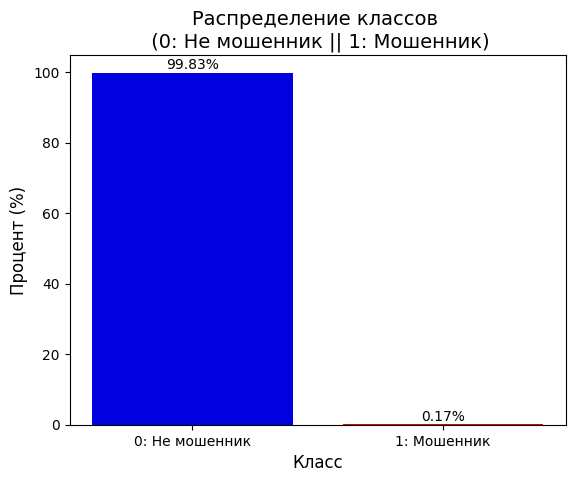

In [27]:
colors = ["#0101DF", "#DF0101"]

plt.bar(['0: Не мошенник', '1: Мошенник'], [n_trans, f_trans], color=colors)

plt.title('Распределение классов \n (0: Не мошенник || 1: Мошенник)', fontsize=14)
plt.ylabel('Процент (%)', fontsize=12)
plt.xlabel('Класс', fontsize=12)

for i, v in enumerate([n_trans, f_trans]):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontsize=10)

plt.show()


Построим распределения по суммам и времени транзакций.

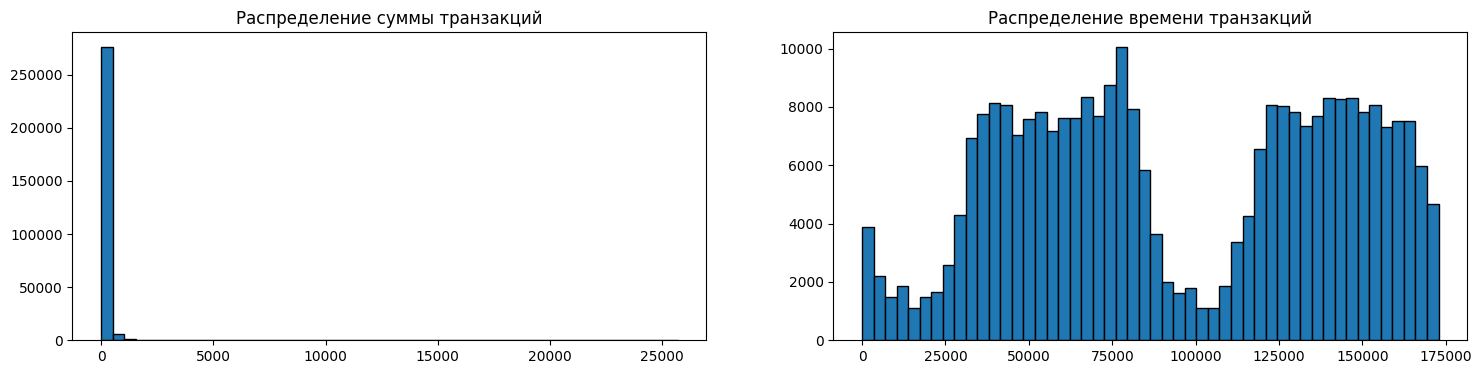

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount']
time_val = df['Time']

# Строим график распределения суммы транзакций
ax[0].hist(amount_val, bins=50, edgecolor='k')
ax[0].set_title('Распределение суммы транзакций')

# Строим график распределения времени транзакций
ax[1].hist(time_val, bins=50, edgecolor='k')
ax[1].set_title('Распределение времени транзакций')

plt.show()

### Масштабирование
Первым делом нам необходимо отмасштабировать столбцы **Time** и **Amount**. Поскольку все остальные признаки уже отмасштабированы. Однако делать это нужно только строго **после** разбиения на обучающую выборку и тестовую.

Затем необходимо создать подвыборку из наших данных, чтобы иметь равное количество случаев мошенничества и не мошенничества, что поможет нашим моделям лучше понять закономерности, определяющие, является ли транзакция мошенничеством или нет.

### Зачем создавать подвыборку?
Наши данные имеют сильный дисбаланс. Использование исходного датасета приведет к следующим проблемам:
  - **Переобучение**: Наши модели классификации будут предполагать, что в большинстве случаев мошенничества не существует! Мы хотим, чтобы наша модель точно определяла, когда происходит мошенничество.
  - **Неверные корреляции:** Хотя мы не знаем, что обозначают признаки "V", будет полезно понять, как каждый из этих признаков влияет на результат (мошенничество или отсутствие мошенничества), поскольку, имея несбалансированный набор данных, мы не можем увидеть истинные корреляции между целевой переменной и признаками.

### Разделение данных
**Важно!**

Прежде, чем приступить к балансировке наших данных, мы должны разделить исходный набор данных. Зачем?

Для определения качества работы наших моделей их необходимо тестировать на **исходном** тестовом наборе, а не на тестовом наборе, созданном после балансировки. Цель балансировки заключается в том, чтобы модель смогла найти закономерности для принятия решения по типу транзакции, поэтому мы выравниваем соотношение между мошенническими транзакциями и обычными. Однако проверять качество мы будем именно в "боевых" условиях с учетом реального распределения данных.




In [29]:
from sklearn.model_selection import train_test_split
# Поскольку большая часть наших данных уже масштабирована, мы должны масштабировать столбцы,
# которые остались (Amount и Time)
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler() # Менее чувствителен к выбросам, чем просто стандартизация

X = df.drop('Class', axis=1)
y = df['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2,
                                                                                    random_state = 42)


# Посмотрим, какие типы данных возвращаются после разделения:
rt_tmp = original_Xtrain['Amount']
print (f'Тип данных original_Xtrain["Amount"] {type(rt_tmp)}')
print (f'Тип данных original_Xtrain["Amount"].values {type(rt_tmp.values)}')
print (f'Данные original_Xtrain["Amount"].values {rt_tmp.values}')
print (f'Тип данных original_Xtrain["Amount"].values.reshape(-1,1) {type(rt_tmp.values.reshape(-1,1))}')
print (f'Данные original_Xtrain["Amount"].values.reshape(-1,1) \n{rt_tmp.values.reshape(-1,1)} \n')



Тип данных original_Xtrain["Amount"] <class 'pandas.core.series.Series'>
Тип данных original_Xtrain["Amount"].values <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values [  9.99  45.9   11.99 ...   3.94   1.   113.  ]
Тип данных original_Xtrain["Amount"].values.reshape(-1,1) <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values.reshape(-1,1) 
[[  9.99]
 [ 45.9 ]
 [ 11.99]
 ...
 [  3.94]
 [  1.  ]
 [113.  ]] 



In [30]:
# вот последнее представление - как раз то, что нужно для RobustScaler . Преобразовываем так все нужные столбцы.

original_Xtrain['scaled_amount'] = rob_scaler.fit_transform(original_Xtrain['Amount'].values.reshape(-1,1))
original_Xtest['scaled_amount'] = rob_scaler.fit_transform(original_Xtest['Amount'].values.reshape(-1,1))

original_Xtrain['scaled_time'] = rob_scaler.fit_transform(original_Xtrain['Time'].values.reshape(-1,1))
original_Xtest['scaled_time'] = rob_scaler.fit_transform(original_Xtest['Time'].values.reshape(-1,1))

original_Xtrain.drop(['Time','Amount'], axis=1, inplace=True)
original_Xtest.drop(['Time','Amount'], axis=1, inplace=True)

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Распределение классов: \n')
print("Обучающий набор:", train_counts_label/ len(original_ytrain))
print("Тестовый набор:", test_counts_label/ len(original_ytest))

Распределение классов: 

Обучающий набор: [0.99827075 0.00172925]
Тестовый набор: [0.99827955 0.00172045]


## Метод Random Under-Sampling

Применим метод *Random Under-Sampling*, который случайным образом удаляет объекты доминирующего класса и выравнивает соотношение классов.

#### Алгоритм:
<ul>
<li>Определяем степень несбалансированности (посчитали количество меток одного и другого класса выше)  </li>
<li>Как только мы определим, сколько случаев считаются мошенническими операциями (Fraud = "1"), мы должны довести количество немошеннических операций до того же количества, что и мошеннических (мы хотим получить соотношение 50/50 между классами), то есть это в подвыборке будет 492 случая мошенничества и 492 случая немошеннических операций.  </li>
<li> После применения этого метода мы получим подвыборку нашего набора данных с соотношением 50/50 в отношении наших классов. Наконец, не забудем <b>перемешать</b> наши данные для того, чтобы модели не зависили от порядка входных данных.</li>
</ul>

**Важно!**

Основная проблема данного метода заключается в том, что мы рискуем тем, что наши модели классификации не будут работать так точно, как нам хотелось бы, поскольку происходит большая потеря информации (выделение всего 492 немошеннических транзакций из 284 315 немошеннических транзакций).

In [31]:
# Поскольку наши классы сильно не сбалансированы, мы должны сделать их эквивалентными,
# чтобы получить нормальное распределение классов.

# Перемешаем данные перед созданием подвыборок

df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492] # берем последние 492 транзакции

print(len(fraud_df))
print(len(non_fraud_df))
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Перемешивание строк датасета
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

492
492


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
253814,156432.0,-0.142633,0.071108,0.987937,-2.040035,0.115867,-0.105251,0.086918,-0.016366,-1.012439,...,0.290148,0.830151,-0.204723,0.459475,-0.206860,-0.225231,0.149946,0.160832,8.00,0
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
240629,150688.0,1.974680,-0.334727,-0.202017,0.525106,-0.744031,-0.603513,-0.530556,-0.121642,1.319781,...,0.205966,0.901164,0.108483,0.098626,-0.064999,-0.219070,0.048206,-0.034033,9.99,0
156990,109298.0,-1.000611,3.346850,-5.534491,6.835802,-0.299803,0.095951,-2.440419,1.286301,-2.766438,...,0.439757,-0.694099,0.299660,-0.657601,0.101648,0.430457,0.824685,0.326952,186.13,1
243699,152036.0,-4.320609,3.199939,-5.799736,6.502330,0.378479,-1.948246,-2.167860,-0.728207,-1.977238,...,0.476660,0.434278,-0.136940,-0.620072,0.642531,0.280717,-2.649107,0.533641,1.00,1


In [32]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/creditcard_full.csv")

In [33]:
new_df.shape

(984, 31)

Распределение классов в подвыборке
Class
0    492
1    492
Name: count, dtype: int64


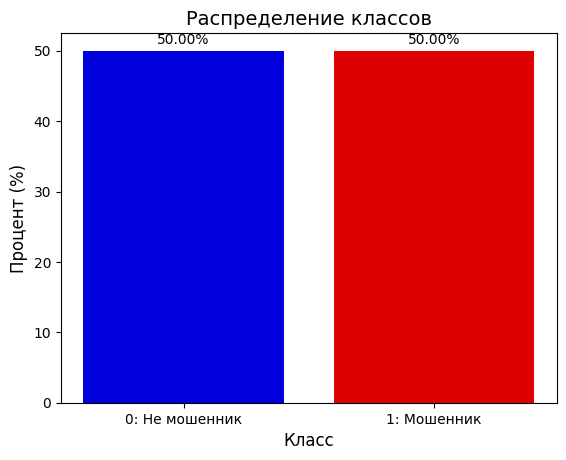

Обычные транзакции составляют  50.0 % данных
Мошеннические транзакции составляют  50.0 % данных


In [34]:
print('Распределение классов в подвыборке')
classes_sample = new_df['Class'].value_counts()
print(classes_sample)
n_trans_sample = classes_sample[0]/len(new_df)*100
f_trans_sample = classes_sample[1]/len(new_df)*100

colors = ["#0101DF", "#DF0101"]

plt.bar(['0: Не мошенник', '1: Мошенник'], [n_trans_sample, f_trans_sample], color=colors)
plt.title('Распределение классов', fontsize=14)
plt.ylabel('Процент (%)', fontsize=12)
plt.xlabel('Класс', fontsize=12)

for i, v in enumerate([n_trans_sample, f_trans_sample]):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontsize=10)

plt.show()
# проверяем снова распределение целевой переменной
print(f'Обычные транзакции составляют  {n_trans_sample} % данных')
print(f'Мошеннические транзакции составляют  {f_trans_sample} % данных')



### Матрица корреляций

Корреляционные матрицы очень важны для понимания данных. Мы хотим узнать, есть ли признаки, которые оказывают сильное влияние на то, является ли конкретная транзакция мошенничеством. Однако важно, чтобы мы использовали сбалансированную подвыборку, чтобы увидеть, какие признаки имеют высокую положительную или отрицательную корреляцию в отношении мошеннических операций.


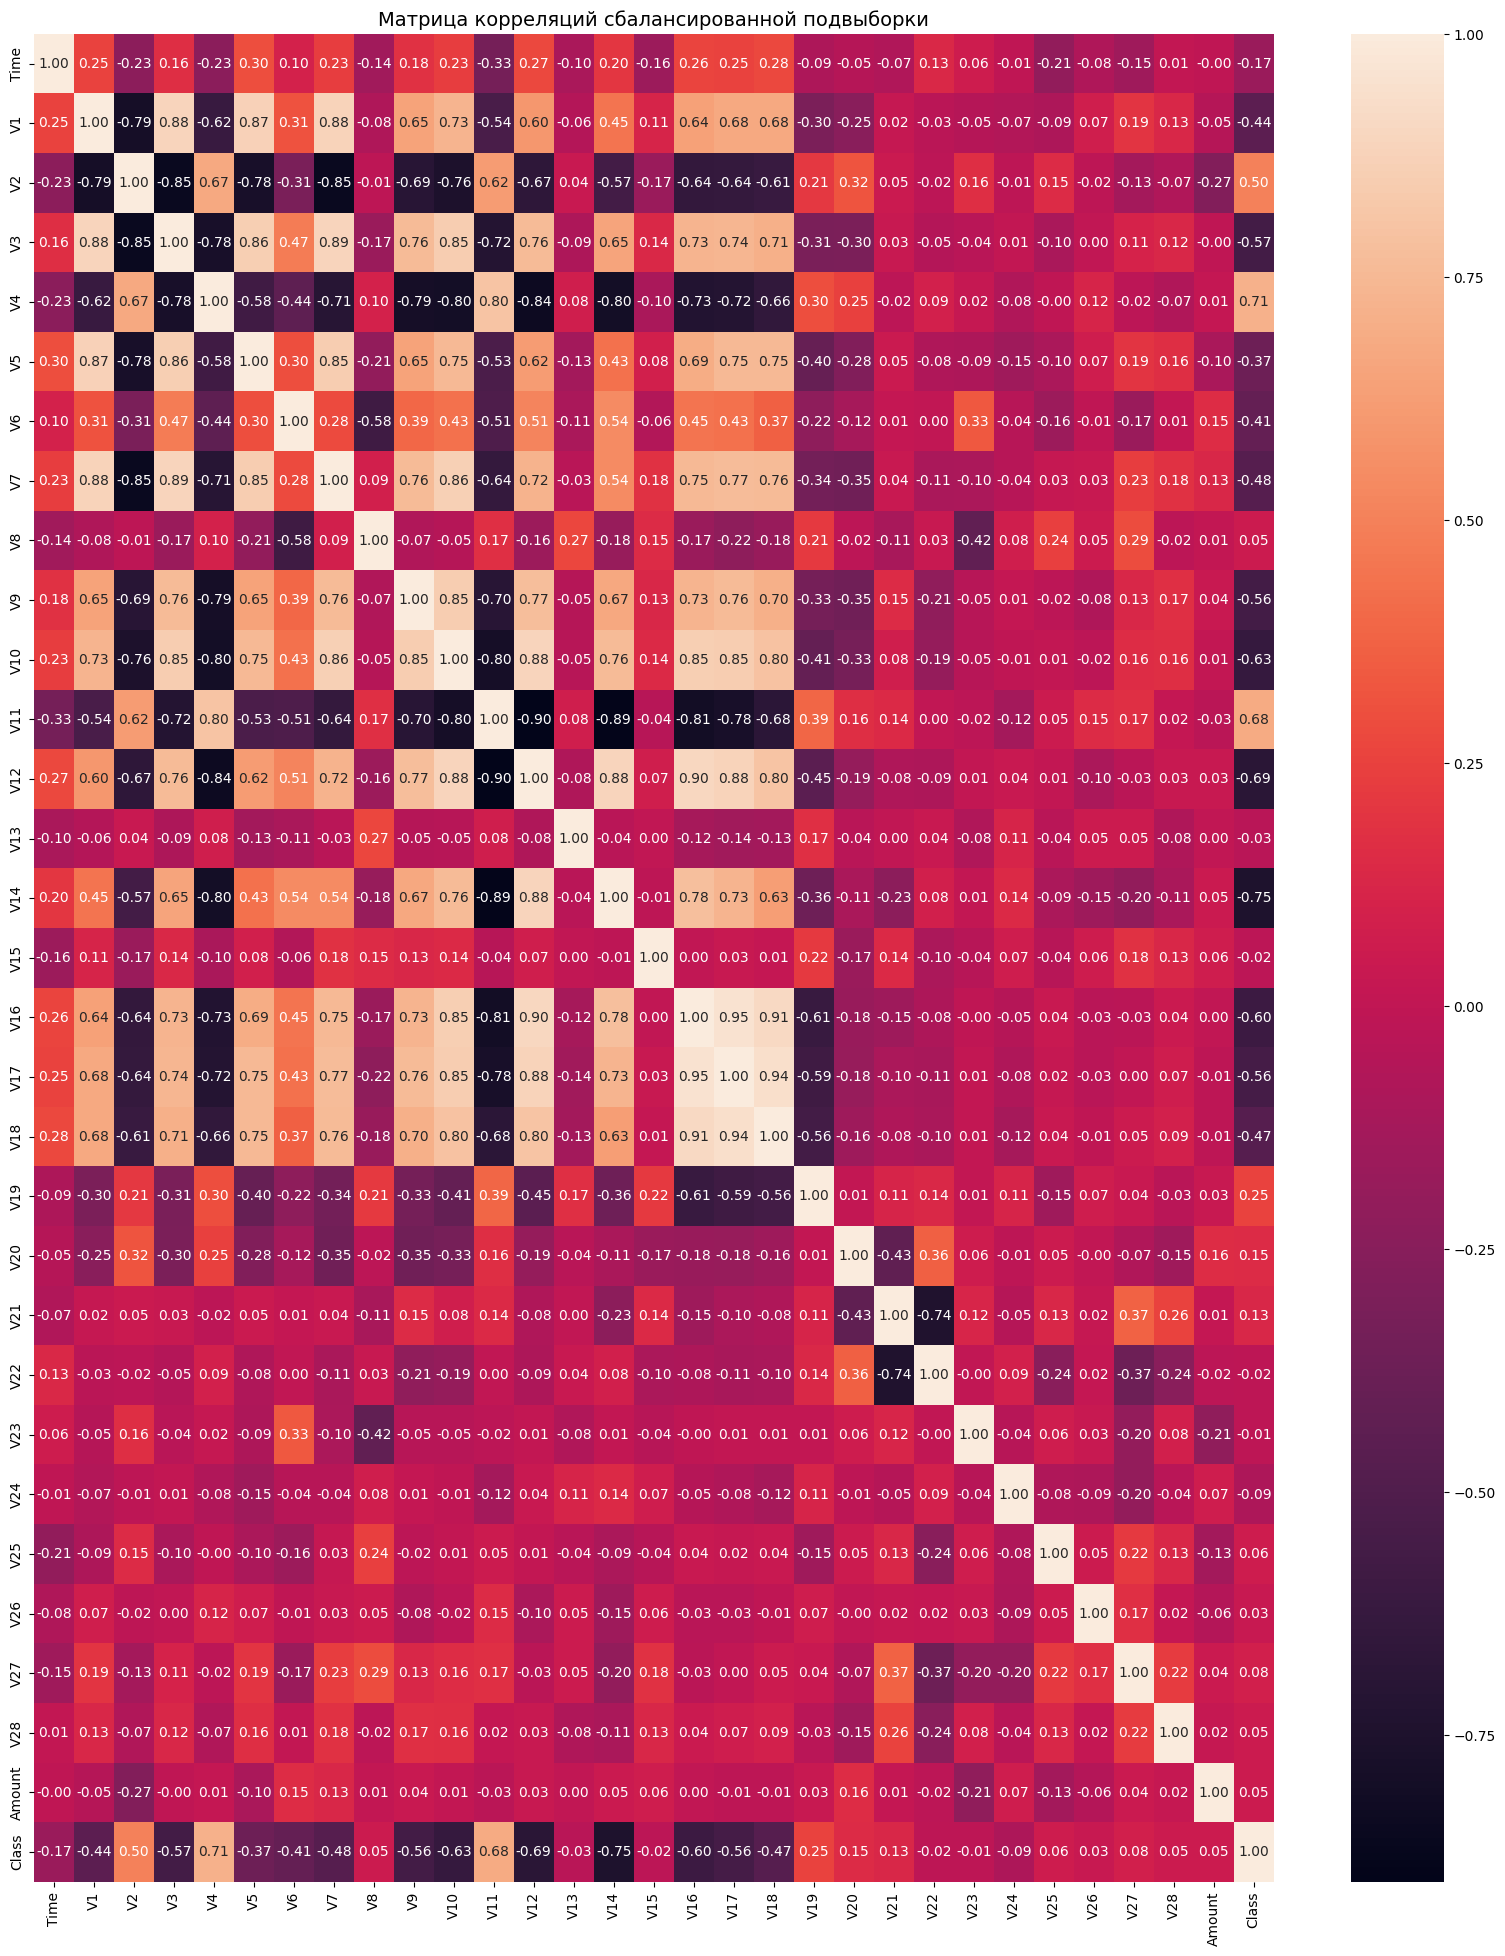

In [35]:
f, ax = plt.subplots(1, 1, figsize=(20, 24))

# Построим матрицу корреляций
corr_matrix = new_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", ax=ax)

ax.set_title('Матрица корреляций сбалансированной подвыборки', fontsize=14)
plt.show()

### Выводы:
<ul>
<li><b>Отрицательные корреляции: </b> Какие признаки  имеют отрицательную корреляцию? Другими словами, чем ниже эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция.  </li>
<li> <b> Положительные корреляции: </b> Какие признаки  положительно коррелируют? То есть, чем выше эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция. </li>
</ul>


**Важно!**

Всегда проверяйте, используете ли вы сбалансированную подвыборку в корреляционной матрице, иначе на корреляционную матрицу повлияет сильный дисбаланс между классами.

Построим теперь Boxplot.

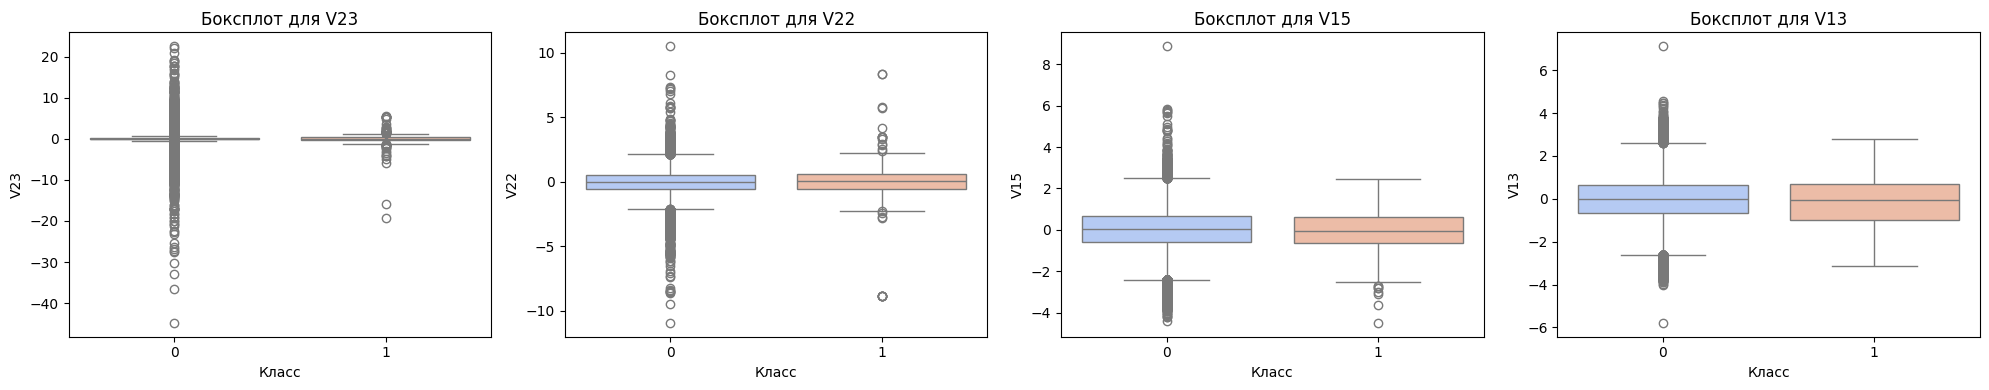

In [36]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Отрицательные корреляции

target_corr = corr_matrix['Class']

neg_corr_features = target_corr[target_corr < 0].sort_values(ascending=False).index.tolist()

# Берём только 4 признака с самой большой отрицательной корреляцией
top_neg_corr_features = neg_corr_features[:4]

# Если меньше 4 признаков, делаем соответствующее количество графиков
axes = axes[:len(top_neg_corr_features)] if len(top_neg_corr_features) < 4 else axes

# Рассчитываем количество строк и столбцов
n_features = len(top_neg_corr_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols  # Округление вверх для строк

axes = axes.flatten()

# Строим боксплоты
for i, feature in enumerate(top_neg_corr_features):
    sns.boxplot(x='Class', y=feature, data=df, palette="coolwarm", ax=axes[i])
    axes[i].set_title(f'Боксплот для {feature}', fontsize=12)
    axes[i].set_xlabel('Класс', fontsize=10)
    axes[i].set_ylabel(feature, fontsize=10)

# Отключаем лишние оси, если их больше, чем графиков
for j in range(len(top_neg_corr_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()




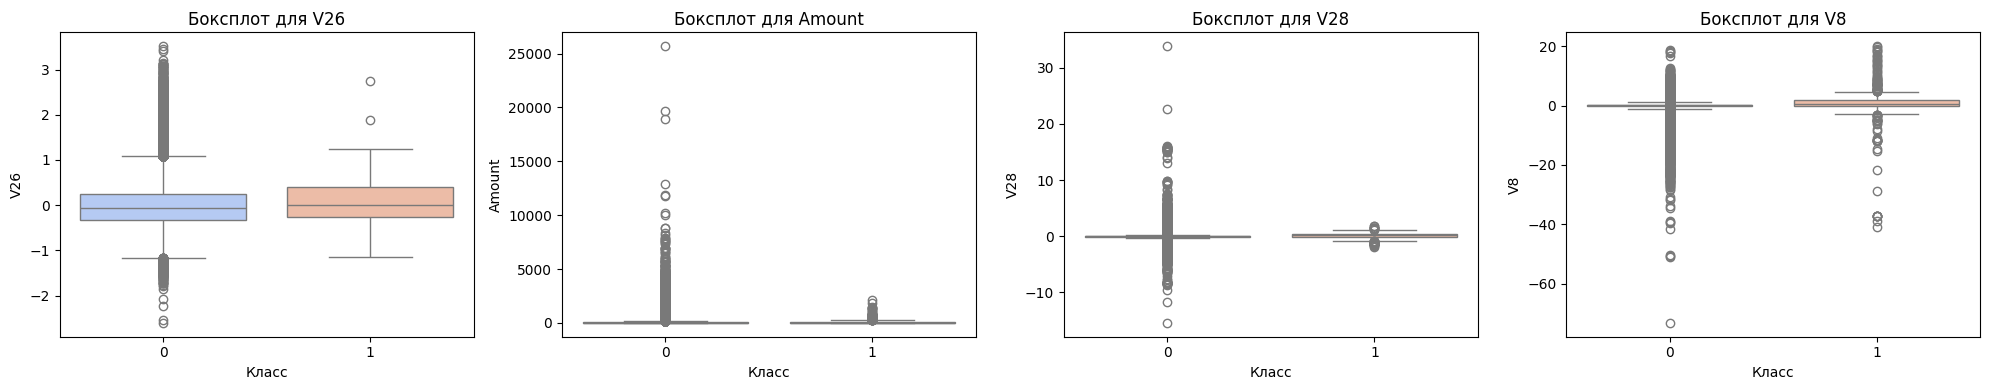

In [37]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Положительные корреляции

pos_corr_features = target_corr[target_corr > 0].sort_values().index.tolist()

top_pos_corr_features = pos_corr_features[:4]

# Если меньше 4 признаков, делаем соответствующее количество графиков
axes = axes[:len(top_pos_corr_features)] if len(top_pos_corr_features) < 4 else axes

# Рассчитываем количество строк и столбцов
n_features = len(top_pos_corr_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols  # Округление вверх для строк

# Создаём подграфики
axes = axes.flatten()

# Строим боксплоты
for i, feature in enumerate(top_pos_corr_features):
    sns.boxplot(x='Class', y=feature, data=df, palette="coolwarm", ax=axes[i])
    axes[i].set_title(f'Боксплот для {feature}', fontsize=12)
    axes[i].set_xlabel('Класс', fontsize=10)
    axes[i].set_ylabel(feature, fontsize=10)

# Отключаем лишние оси, если их больше, чем графиков
for j in range(len(top_pos_corr_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()




# Какие выводы можно сделать по построенным Boxplot?

Напоминаю.

0 - это не мошеннические транзакции

1 - мошеннические транзакции

## Обработка выбросов

Наша основная цель в этом разделе - удалить выбросы из признаков, которые имеют высокую корреляцию с целевой переменной. Это положительно скажется на точности наших моделей.


### Метод межквартильного размаха:
<ul>
<li> <b>Interquartile Range (IQR): </b> Рассчитываем разницу между 75-м процентилем и 25-м процентилем. Наша цель - создать порог за пределами 75-го и 25-го процентилей, чтобы в случае, если какой-то экземпляр выборки преодолеет этот порог, он был удален.  </li>
<li> <b>Построить Boxplots: </b> С помощью boxplot легко увидеть 25-й и 75-й процентили и выбросы. </li>
</ul>

Надо быть внимательным к тому, как далеко мы хотим установить порог для удаления выбросов. Мы определяем порог путем умножения числа (например, 1.5) на интерквартильный размах. Чем выше этот порог, тем меньше выбросов будет обнаружено, а чем ниже этот порог, тем больше выбросов будет обнаружено.  <br><br>

Мы хотим больше сосредоточиться именно на сильных выбросах, а не просто на выбросах. Почему? Потому что удалив все выбросы, мы можем столкнуться с риском потери информации, что приведет к снижению точности наших моделей.


### Итого:
<ul>
<li> <b> Строим распределения </b>  </li>
<li><b>Определяем порог </b> </li>
<li> <b>Удаляем выбросы </b> </li>
<li> <b> Строим Boxplot </b> </li>
</ul>

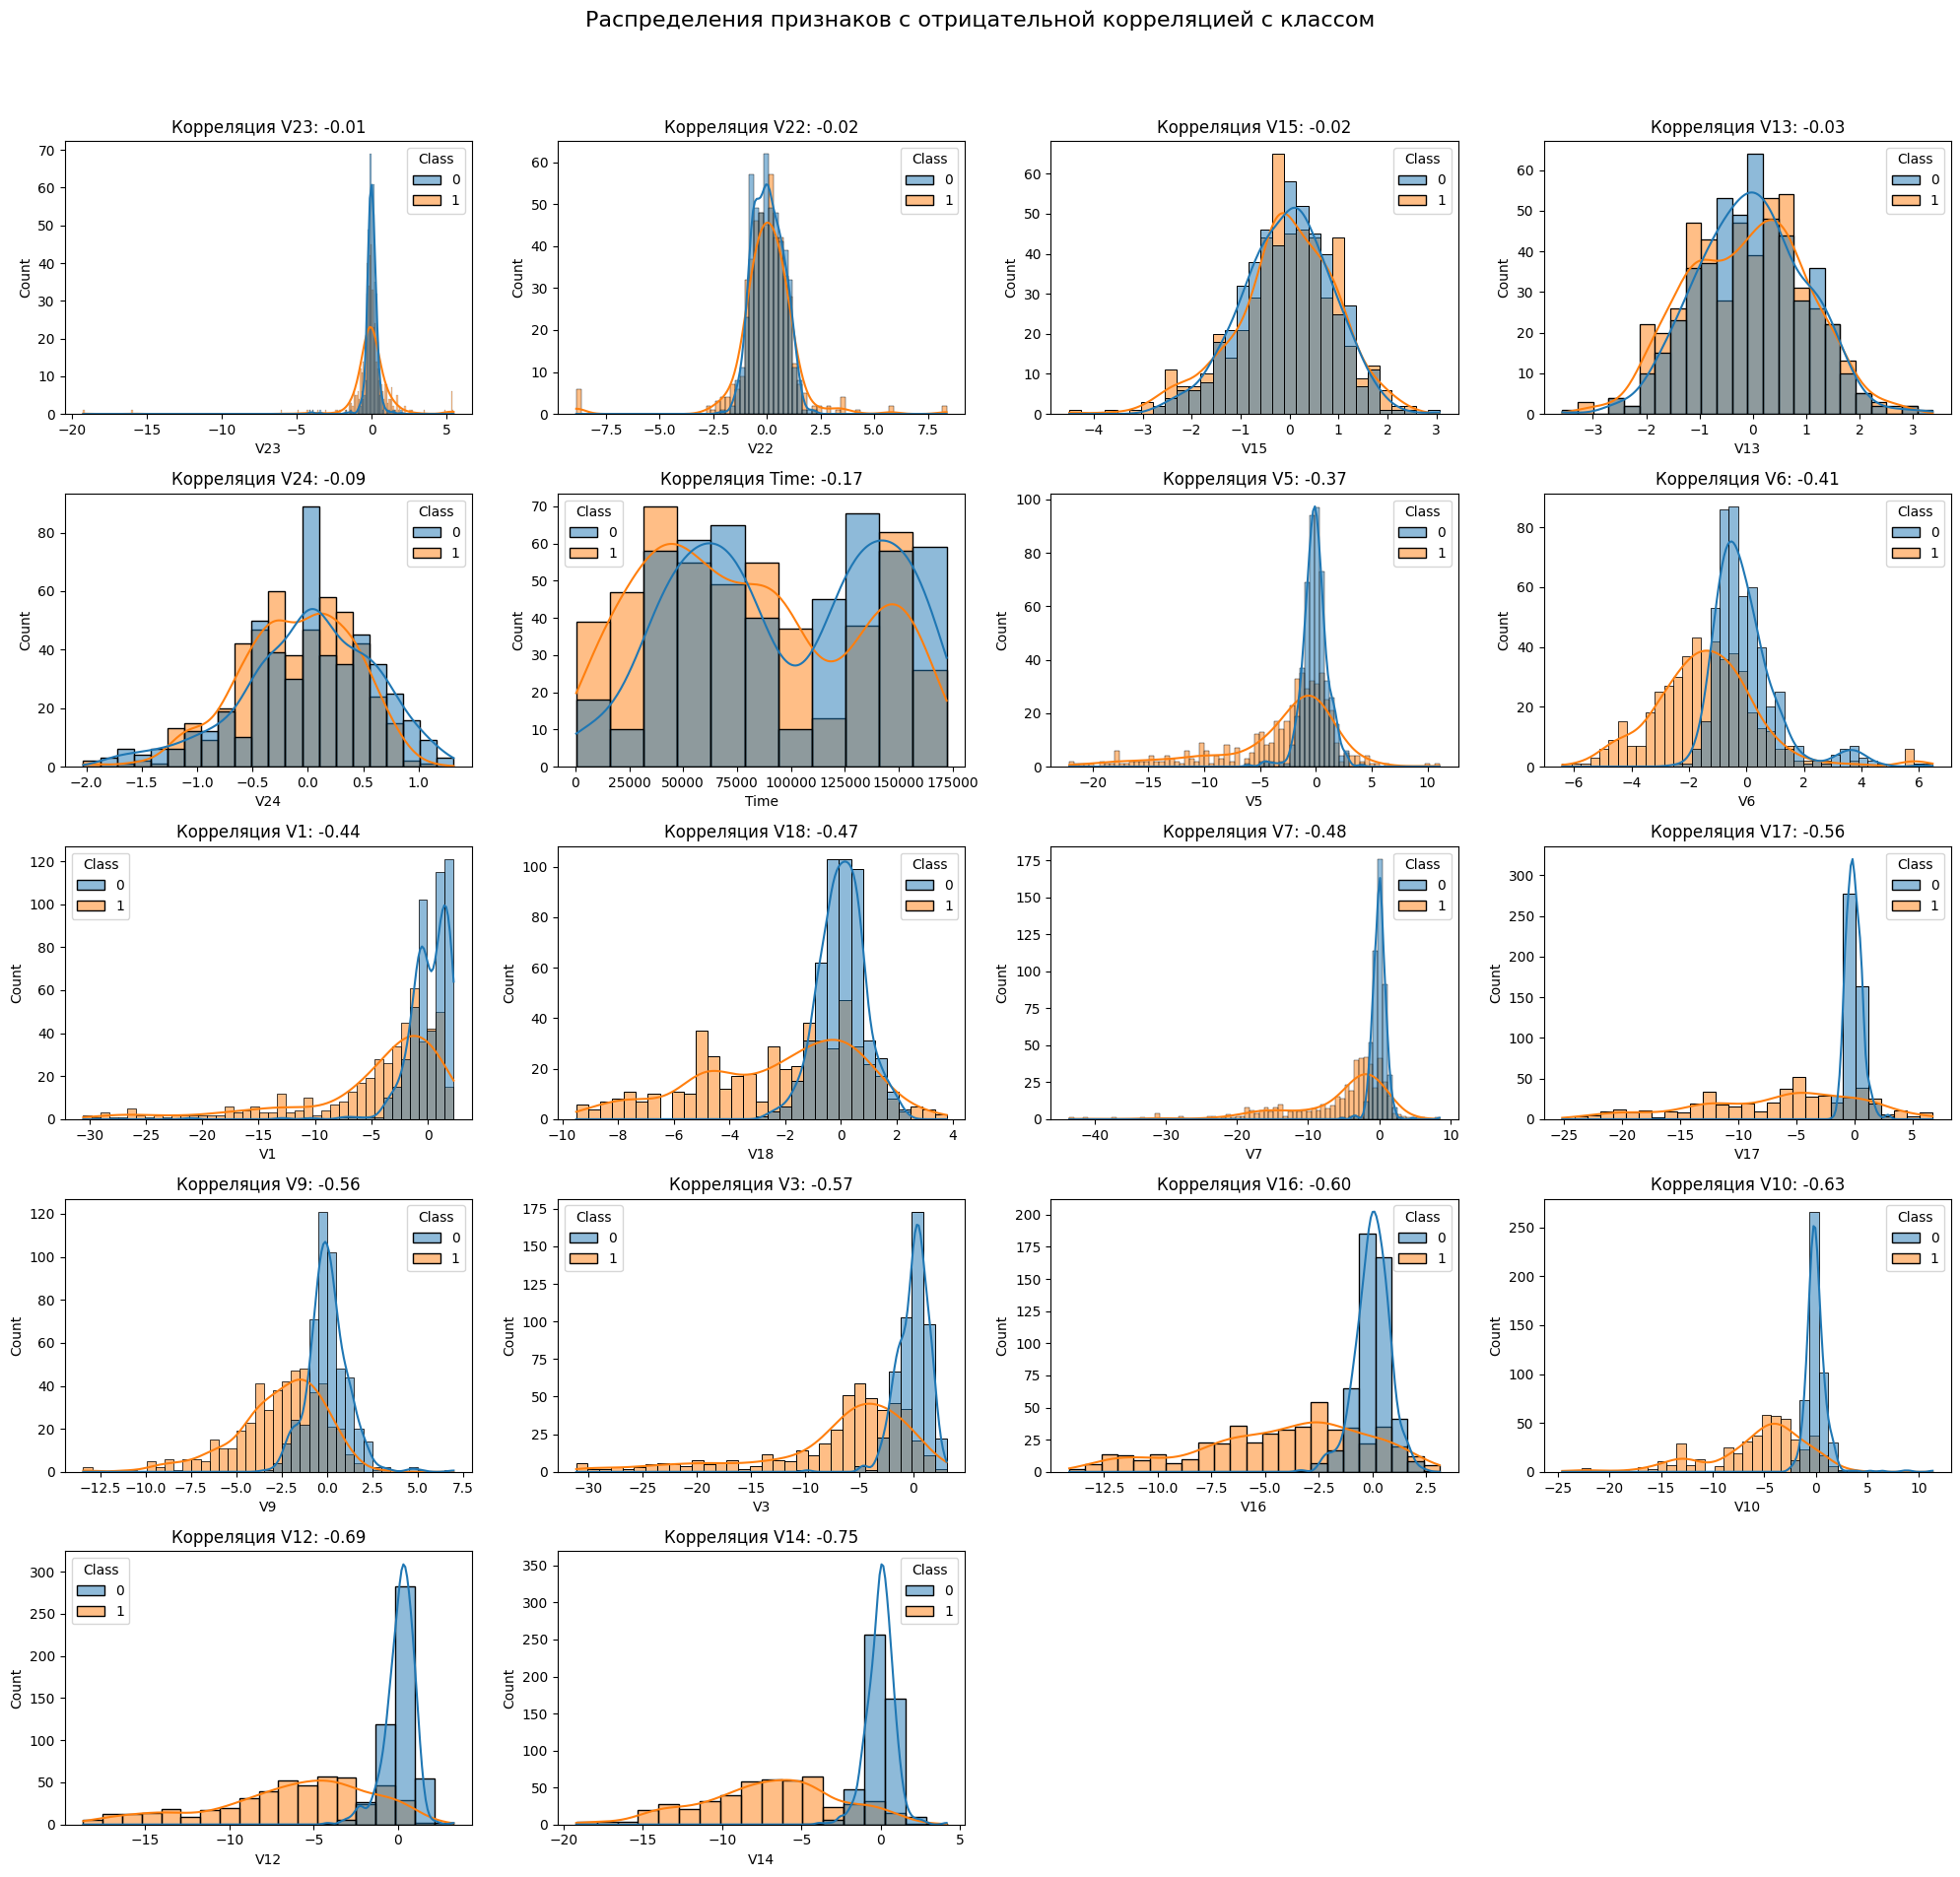

In [38]:
# Строим распределения для признаков с отрицательной корреляцией
num_features = len(neg_corr_features)
num_rows = (num_features // 4) + (1 if num_features % 4 != 0 else 0)

fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 4 * num_rows))
fig.suptitle('Распределения признаков с отрицательной корреляцией с классом', fontsize=16)

# Плоский массив осей для упрощения индексации
axes = axes.flatten()

for i, feature in enumerate(neg_corr_features):
    sns.histplot(data=new_df, x=feature, hue="Class", kde=True, ax=axes[i])
    axes[i].set_title(f'Корреляция {feature}: {corr_matrix["Class"][feature]:.2f}')

# Удаление пустых графиков, если признаков меньше, чем ячеек
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

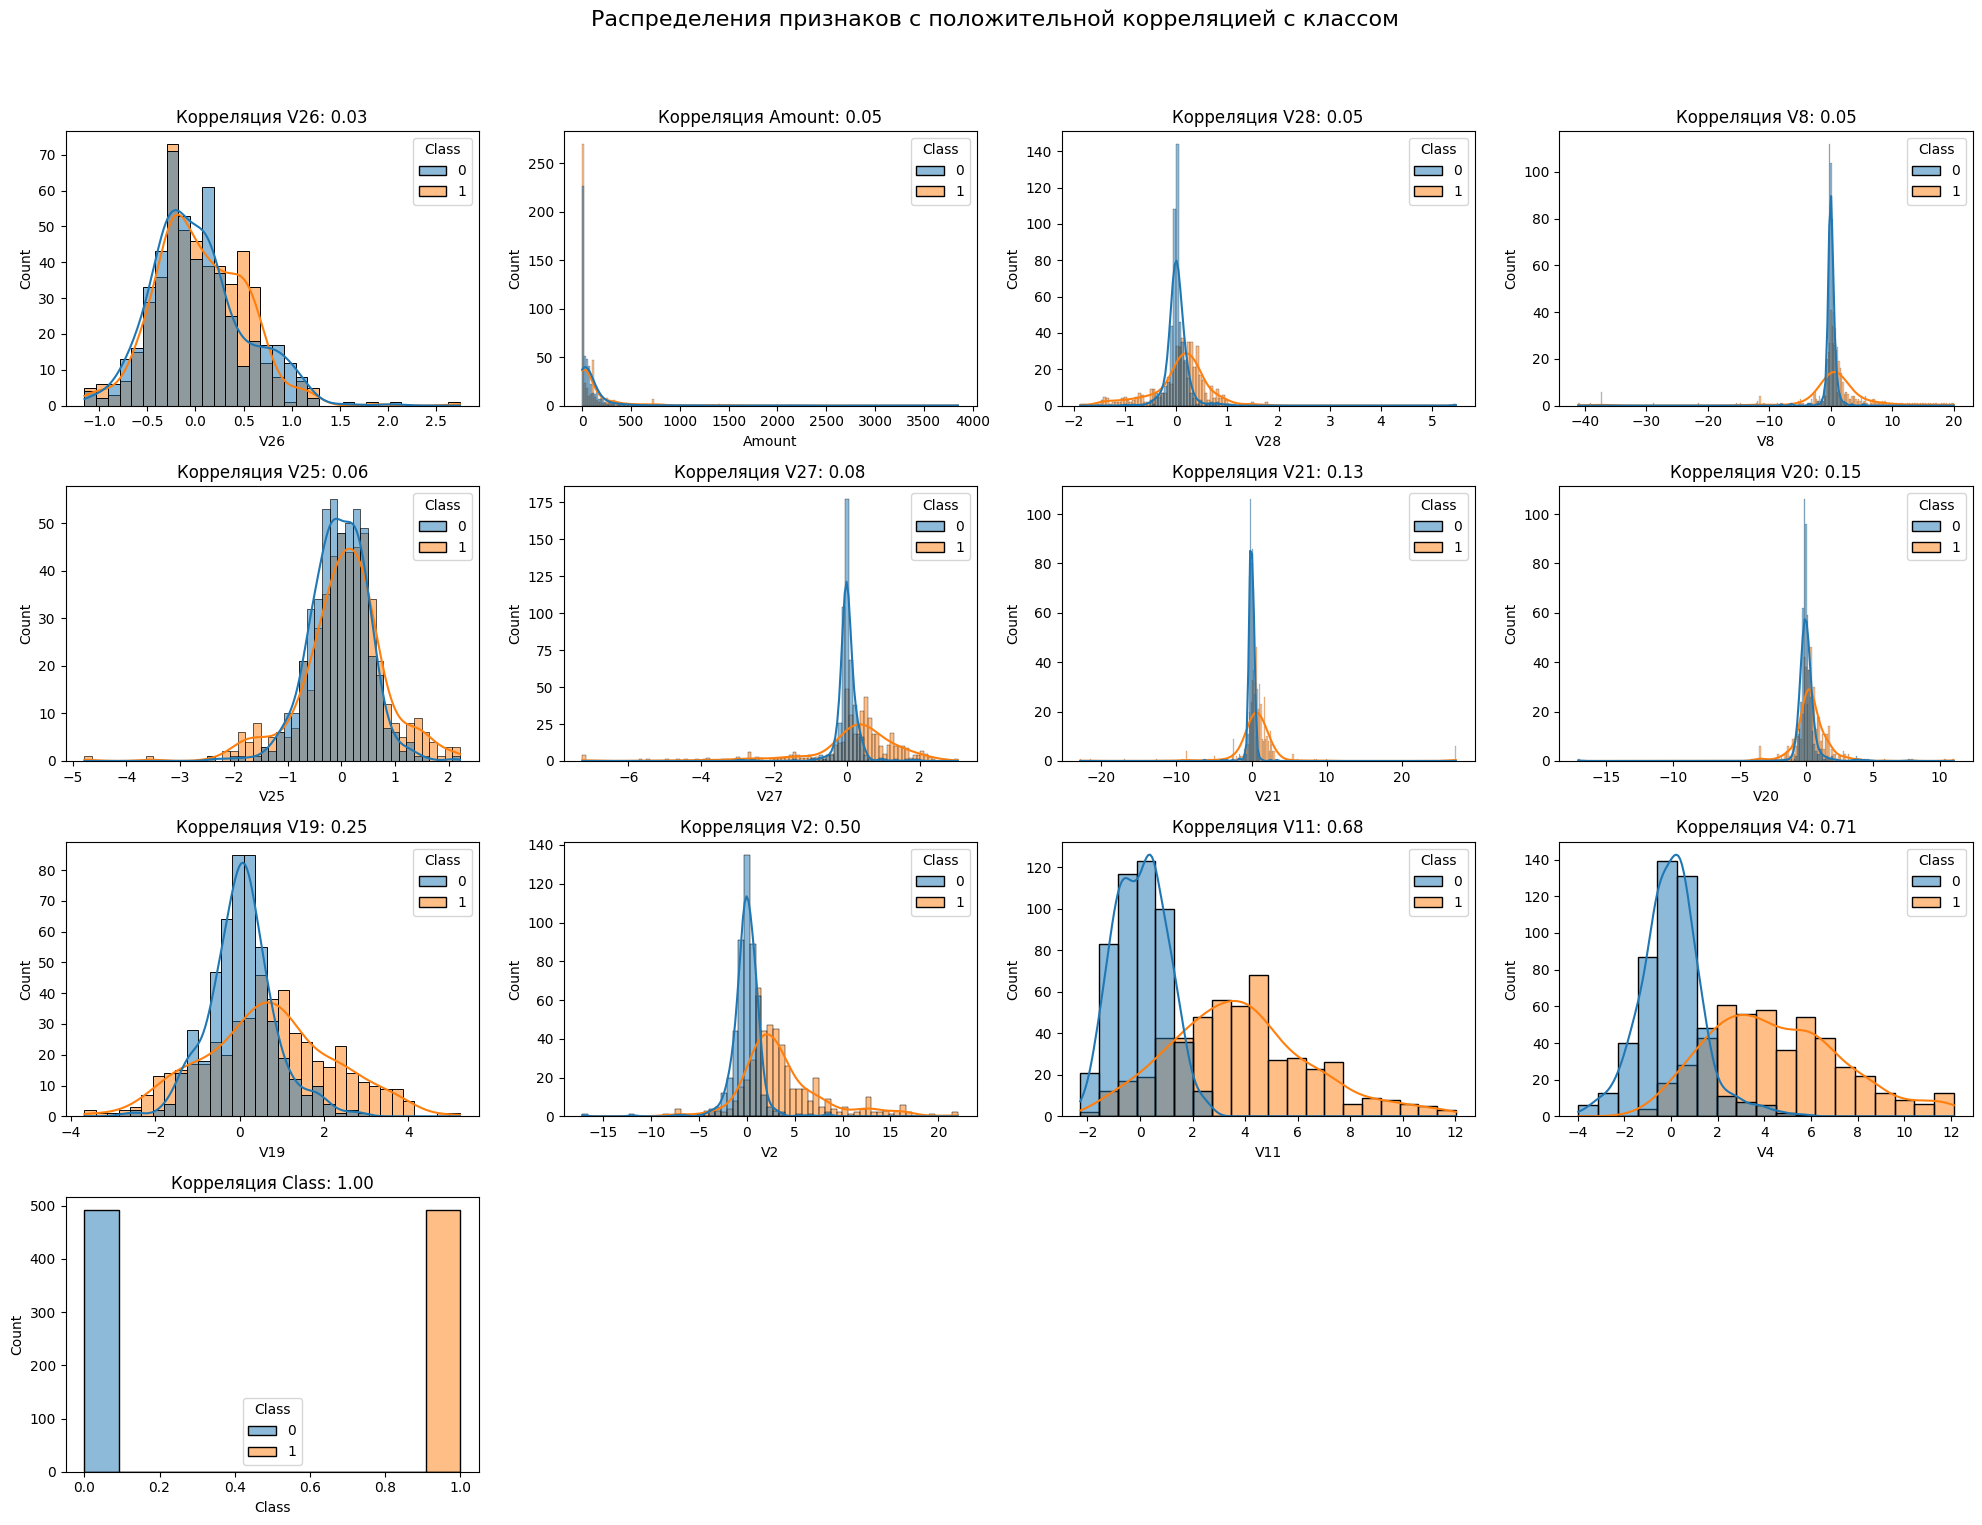

In [39]:
# Строим распределения для признаков с отрицательной корреляцией
num_features = len(pos_corr_features)
num_rows = (num_features // 4) + (1 if num_features % 4 != 0 else 0)

fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 4 * num_rows))
fig.suptitle('Распределения признаков с положительной корреляцией с классом', fontsize=16)

# Плоский массив осей для упрощения индексации
axes = axes.flatten()

for i, feature in enumerate(pos_corr_features):
    sns.histplot(data=new_df, x=feature, hue="Class", kde=True, ax=axes[i])
    axes[i].set_title(f'Корреляция {feature}: {corr_matrix["Class"][feature]:.2f}')

# Удаление пустых графиков, если признаков меньше, чем ячеек
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [45]:
# Удаление выбросов из признака V17
v17_fraud = new_df['V17'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v17_fraud, 25), np.percentile(v17_fraud, 75)
print('Квартиль 25: {} | Квартиль 75: {}'.format(q25, q75))
v17_iqr = q75 - q25
print('iqr: {}'.format(v17_iqr))

v17_cut_off = v17_iqr * 1.5
v17_lower, v17_upper = q25 - v17_cut_off, q75 + v17_cut_off
print('Порог: {}'.format(v17_cut_off))
print('V17 нижняя граница: {}'.format(v17_lower))
print('V17 верхняя граница: {}'.format(v17_upper))

outliers = [x for x in v17_fraud if x < v17_lower or x > v17_upper]
print('Количество выбросов: {}'.format(len(outliers)))

new_df_without_outliers  = new_df.drop(new_df[(new_df['V17'] > v17_upper) | (new_df['V17'] < v17_lower)].index)
print('----' * 44)



#### Для остальных признаков на основе V17 описать функцию, в качастве параметра которой будут вытупать выбросы других признаков
### Написать вызов функции по нужным признакам

Квартиль 25: -11.945057187644576 | Квартиль 75: -1.34193993162032
iqr: 10.603117256024255
Порог: 15.904675884036383
V17 нижняя граница: -27.84973307168096
V17 верхняя граница: 14.562735952416062
Количество выбросов: 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [40]:
old_df = new_df

In [41]:
def delete_outliers(df, feature):
  feature_fraud = df[feature].loc[df['Class'] == 1].values
  q25, q75 = np.percentile(feature_fraud, 25), np.percentile(feature_fraud, 75)
  print('feature = ' + feature)
  print('Квартиль 25: {} | Квартиль 75: {}'.format(q25, q75))
  feature_iqr = q75 - q25
  print('iqr: {}'.format(feature_iqr))

  feature_cut_off = feature_iqr * 1.5
  feature_lower, feature_upper = q25 - feature_cut_off, q75 + feature_cut_off
  print('Порог: {}'.format(feature_cut_off))
  print(feature + ' нижняя граница: {}'.format(feature_lower))
  print(feature + ' верхняя граница: {}'.format(feature_lower))

  outliers = [x for x in feature_fraud if x < feature_lower or x > feature_upper]
  print('Количество выбросов: {}'.format(len(outliers)))

  df_without_outliers  = df.drop(df[(df[feature] > feature_upper) | (df[feature] < feature_lower)].index)
  print('----' * 44)
  return df_without_outliers

In [ ]:
# f, ax = plt.subplots(4, 2, figsize=(20,40))

# colors = ['#B3F9C5', '#f9c5b3']

# # Boxplot для признака V17 после удаления выбросов


# # Boxplot для признака V17 до удаления выбросов


# # И для остальных признаков тоже



# plt.show()

In [42]:
def plot_outliers(df, feature):
    # Выявление и удаление выбросов
    df_without_outliers = delete_outliers(df, feature)

    # Создание графиков
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    colors = ['#B3F9C5', '#f9c5b3']

    # Boxplot для признака до удаления выбросов
    sns.boxplot(x='Class', y=feature, data=df, ax=axes[0], palette=[colors[1]])
    axes[0].set_title(f'Boxplot для признака {feature} ДО удаления выбросов')

    # Boxplot для признака после удаления выбросов
    sns.boxplot(x='Class', y=feature, data=df_without_outliers, ax=axes[1], palette=[colors[0]])
    axes[1].set_title(f'Boxplot для признака {feature} ПОСЛЕ удаления выбросов')

    plt.tight_layout()
    plt.show()

    return df_without_outliers

In [46]:
# теперь у нас в датафрейме new_df будут лежать данные без выбросов.

new_df = new_df_without_outliers

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
feature = Time
Квартиль 25: 41241.5 | Квартиль 75: 128483.0
iqr: 87241.5
Порог: 130862.25
Time нижняя граница: -89620.75
Time верхняя граница: -89620.75
Количество выбросов: 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


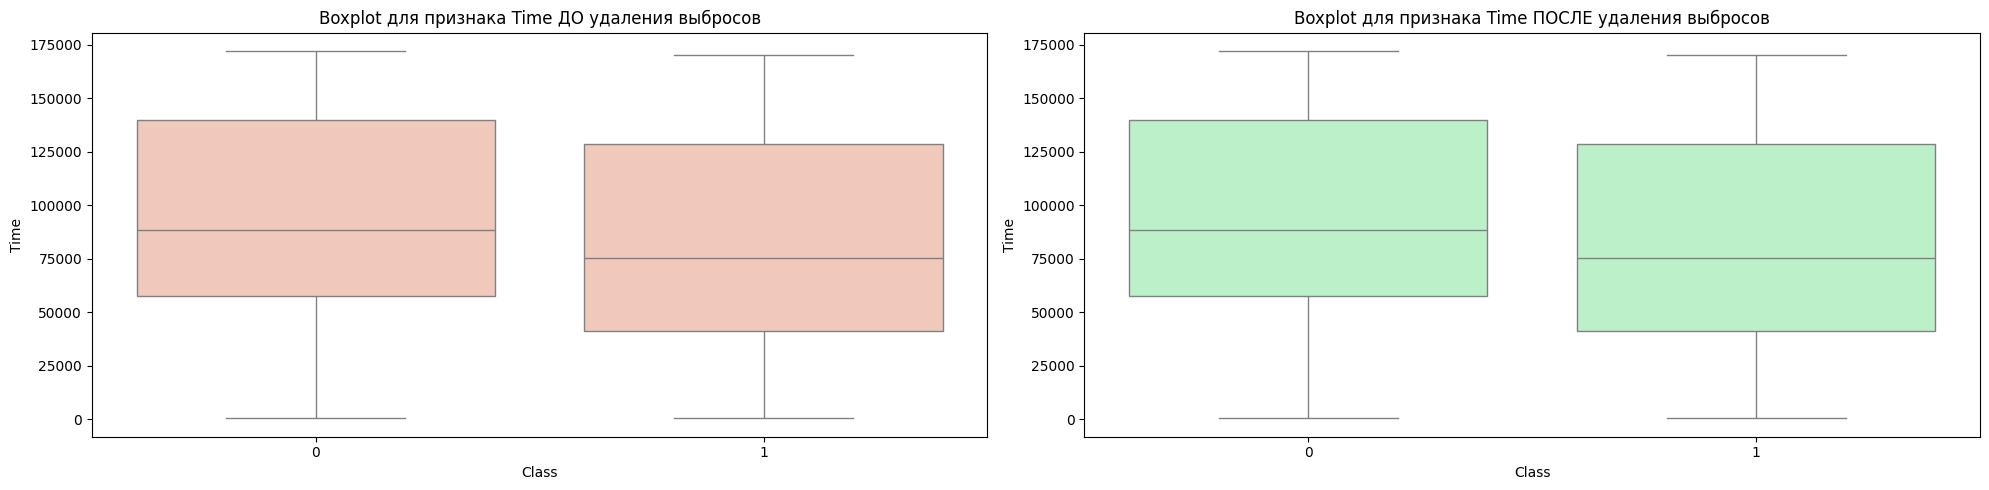

feature = V1
Квартиль 25: -6.03606299434868 | Квартиль 75: -0.419200076257679
iqr: 5.616862918091001
Порог: 8.4252943771365
V1 нижняя граница: -14.461357371485182
V1 верхняя граница: -14.461357371485182
Количество выбросов: 52
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


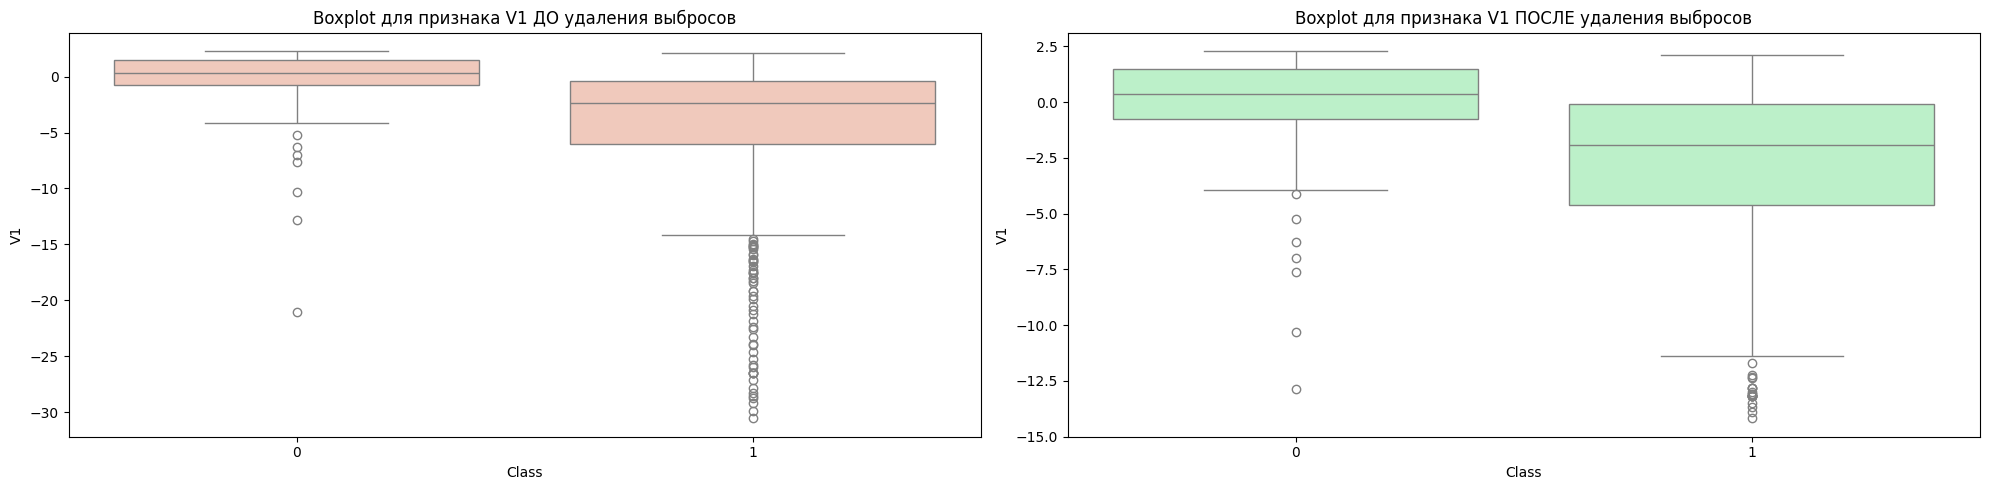

feature = V2
Квартиль 25: 1.1882258198658224 | Квартиль 75: 4.9712573249056025
iqr: 3.78303150503978
Порог: 5.67454725755967
V2 нижняя граница: -4.486321437693848
V2 верхняя граница: -4.486321437693848
Количество выбросов: 46
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


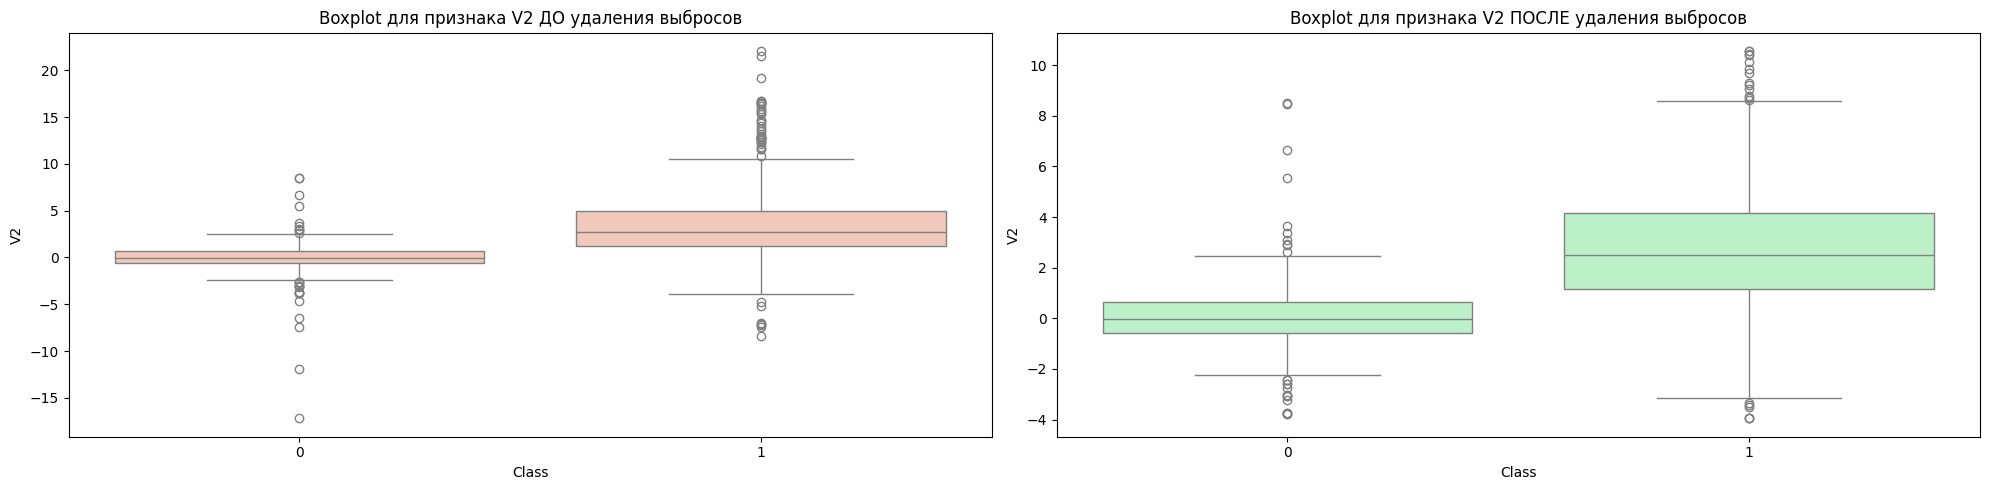

feature = V3
Квартиль 25: -8.643489255766207 | Квартиль 75: -2.27618472719291
iqr: 6.367304528573297
Порог: 9.550956792859946
V3 нижняя граница: -18.194446048626155
V3 верхняя граница: -18.194446048626155
Количество выбросов: 53
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


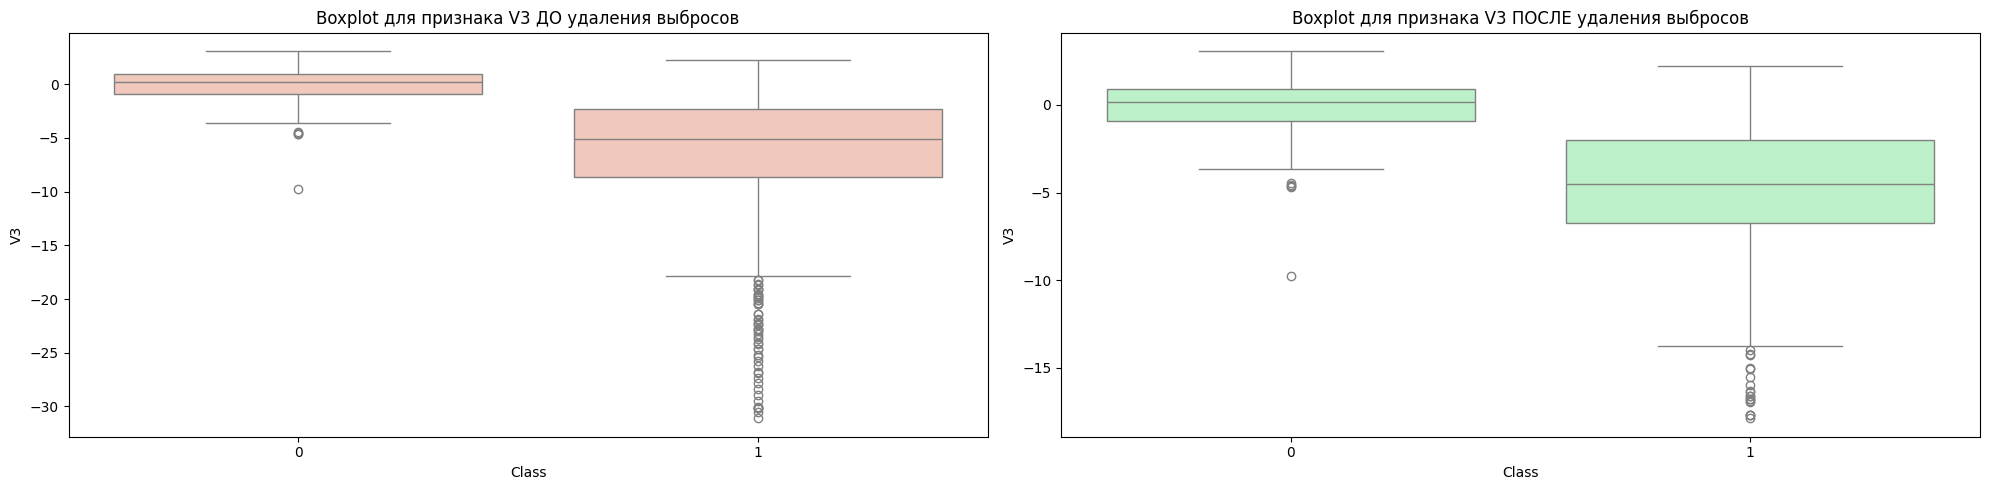

feature = V4
Квартиль 25: 2.373049531845565 | Квартиль 75: 6.3487294567140955
iqr: 3.9756799248685306
Порог: 5.963519887302796
V4 нижняя граница: -3.5904703554572315
V4 верхняя граница: -3.5904703554572315
Количество выбросов: 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


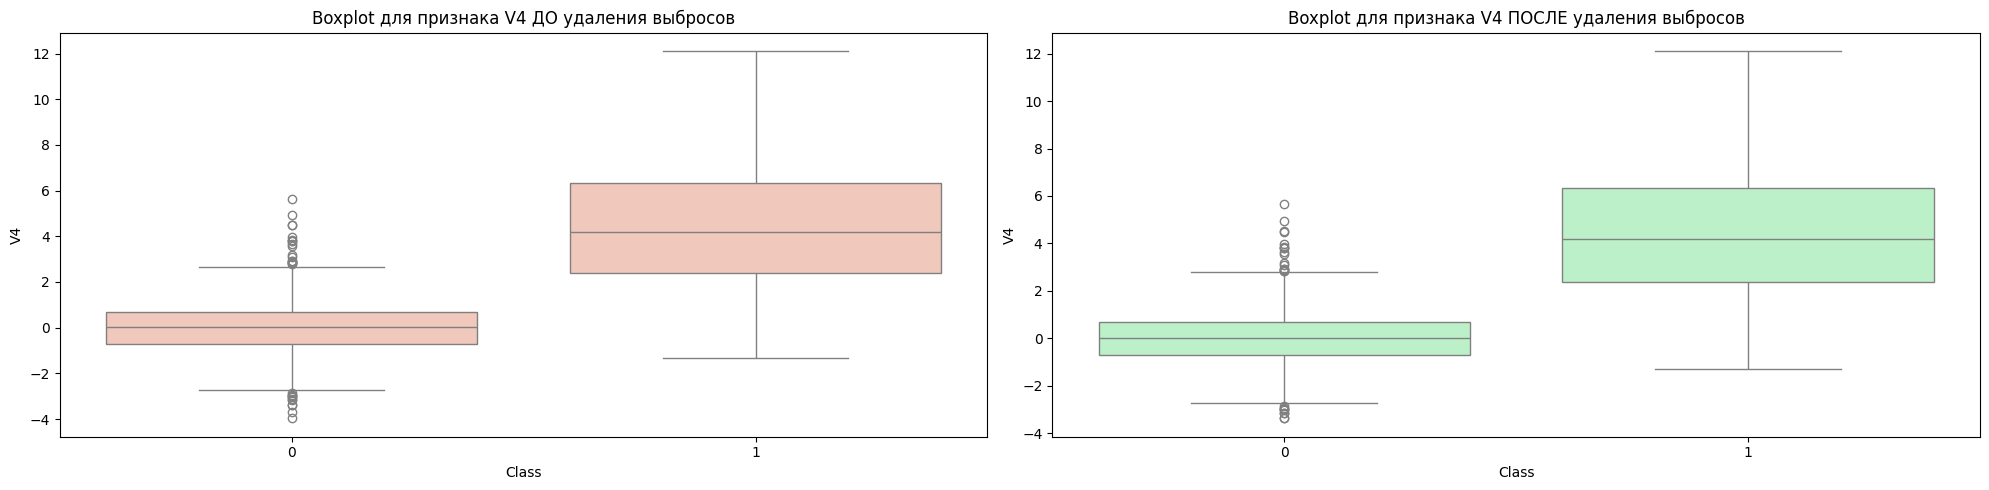

feature = V5
Квартиль 25: -4.79283487176241 | Квартиль 75: 0.21456159835449123
iqr: 5.007396470116901
Порог: 7.511094705175351
V5 нижняя граница: -12.303929576937762
V5 верхняя граница: -12.303929576937762
Количество выбросов: 45
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


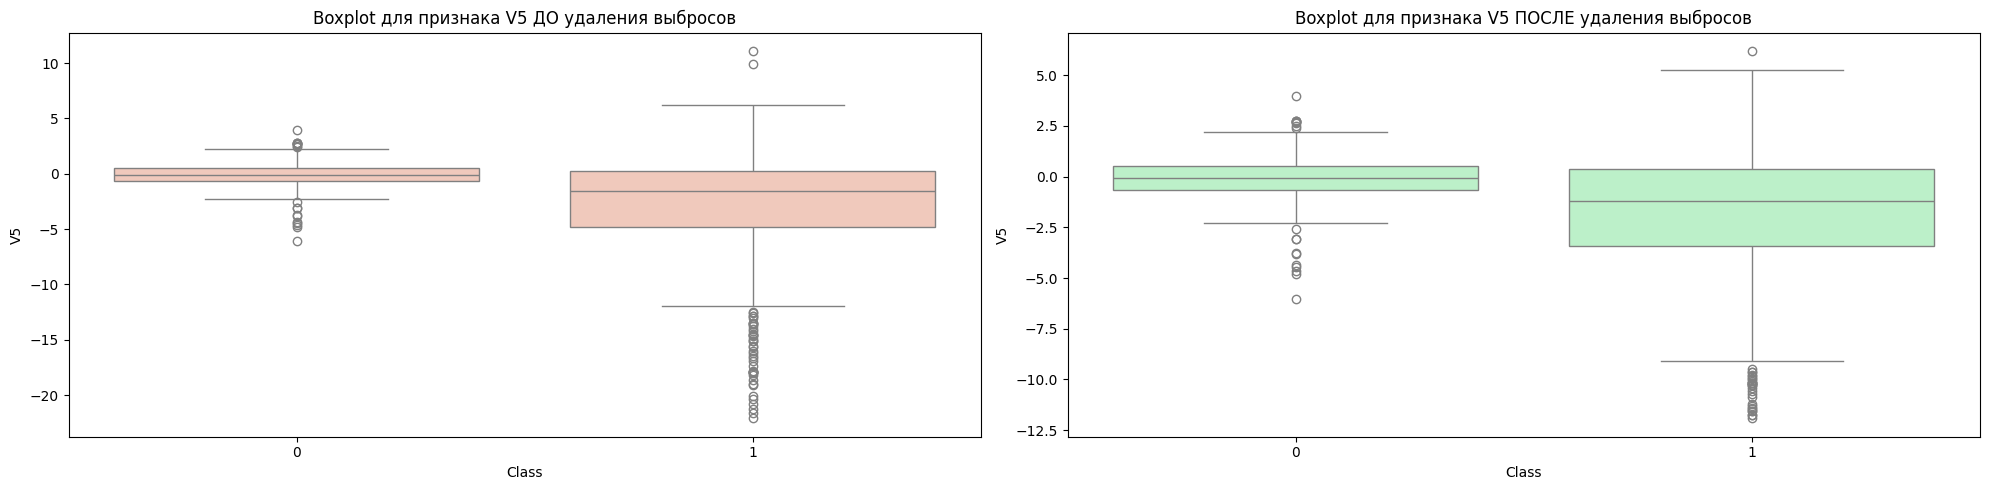

feature = V6
Квартиль 25: -2.5015110887752776 | Квартиль 75: -0.41321639049909276
iqr: 2.0882946982761847
Порог: 3.132442047414277
V6 нижняя граница: -5.633953136189555
V6 верхняя граница: -5.633953136189555
Количество выбросов: 15
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


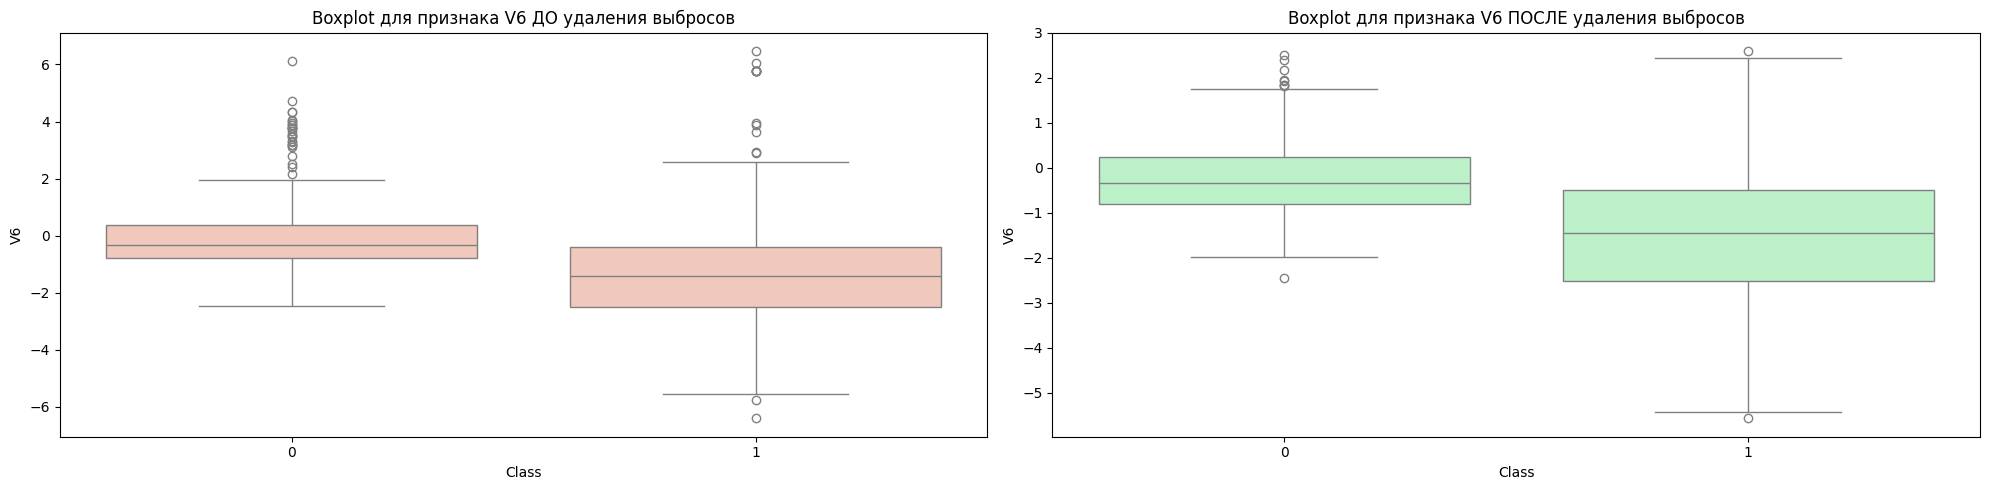

feature = V7
Квартиль 25: -7.965294839932833 | Квартиль 75: -0.945954357800134
iqr: 7.019340482132699
Порог: 10.529010723199049
V7 нижняя граница: -18.49430556313188
V7 верхняя граница: -18.49430556313188
Количество выбросов: 30
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


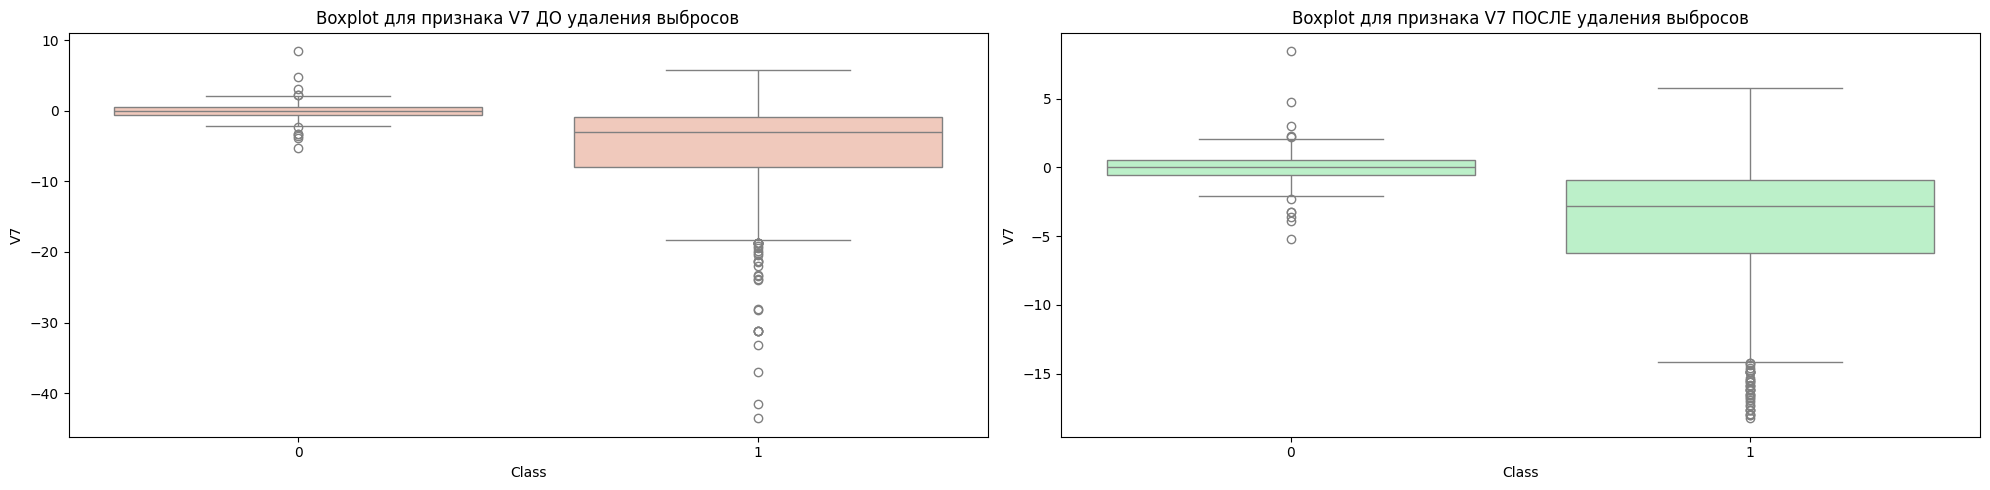

feature = V8
Квартиль 25: -0.1953361735470345 | Квартиль 75: 1.76487895283846
iqr: 1.9602151263854946
Порог: 2.9403226895782417
V8 нижняя граница: -3.1356588631252764
V8 верхняя граница: -3.1356588631252764
Количество выбросов: 98
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


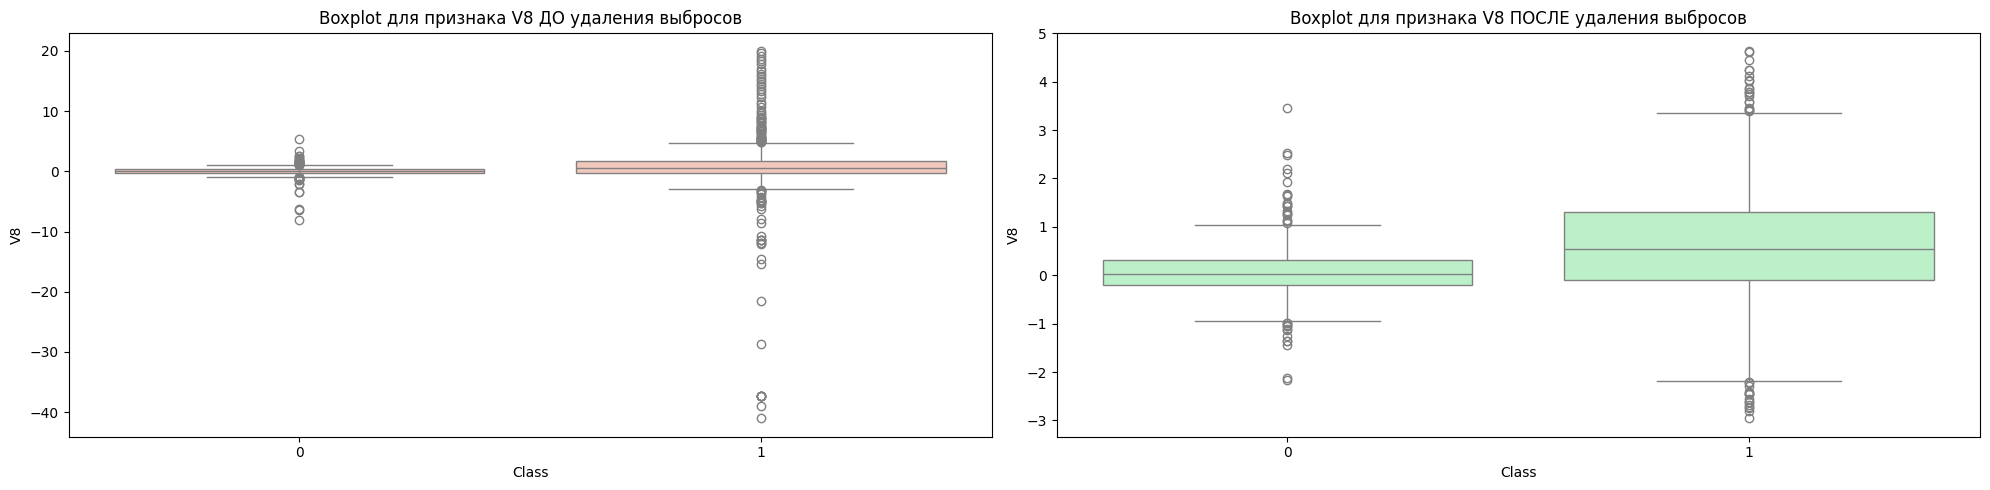

feature = V9
Квартиль 25: -3.8723833348888625 | Квартиль 75: -0.7878501277025964
iqr: 3.084533207186266
Порог: 4.626799810779399
V9 нижняя граница: -8.499183145668262
V9 верхняя граница: -8.499183145668262
Количество выбросов: 17
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


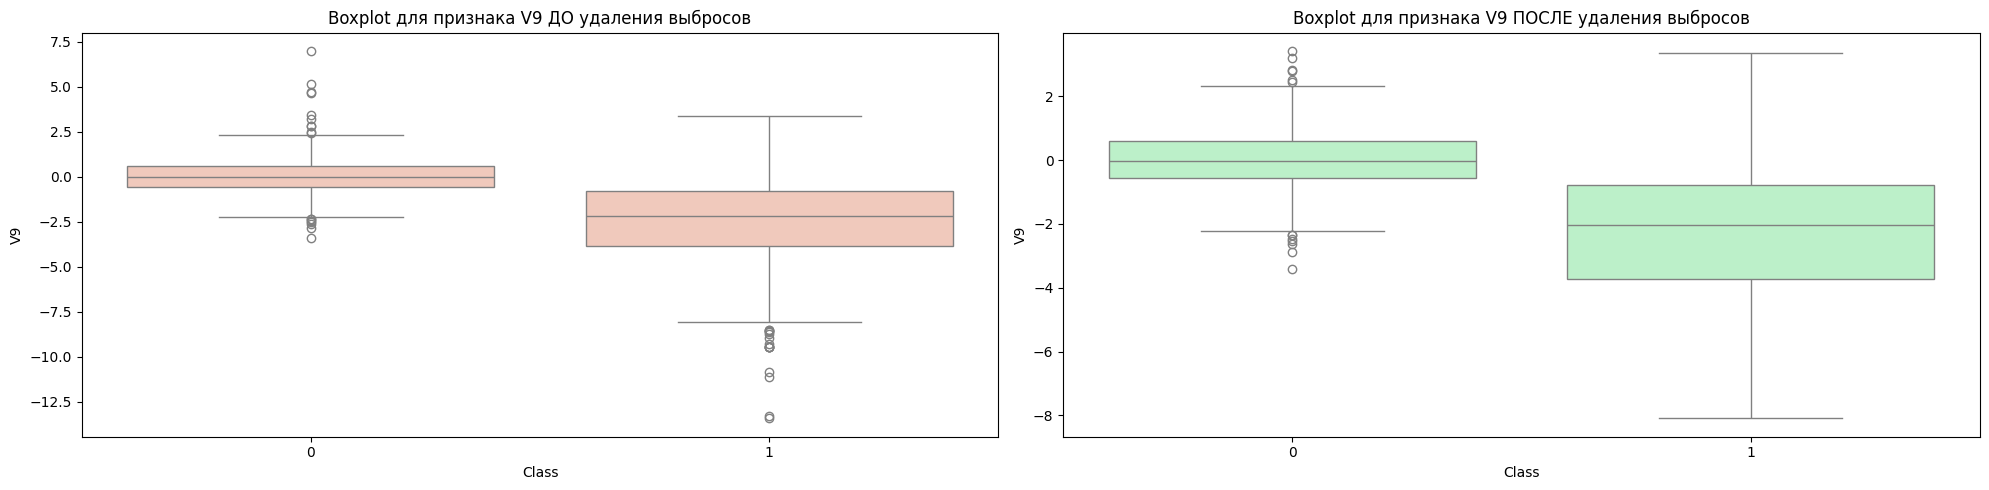

feature = V10
Квартиль 25: -7.7566982278474725 | Квартиль 75: -2.6141839131895623
iqr: 5.142514314657911
Порог: 7.713771471986866
V10 нижняя граница: -15.47046969983434
V10 верхняя граница: -15.47046969983434
Количество выбросов: 19
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


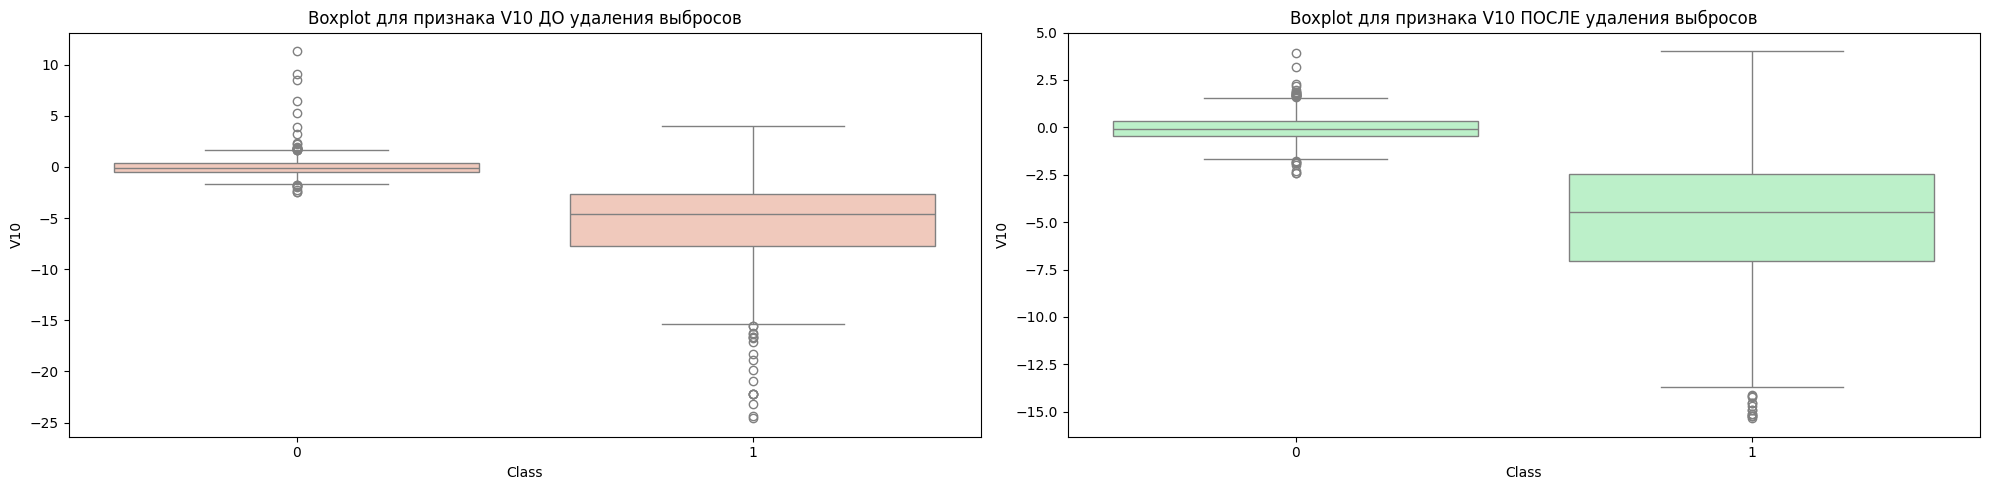

feature = V11
Квартиль 25: 1.973396660607005 | Квартиль 75: 5.307077600096335
iqr: 3.33368093948933
Порог: 5.000521409233995
V11 нижняя граница: -3.0271247486269903
V11 верхняя граница: -3.0271247486269903
Количество выбросов: 10
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


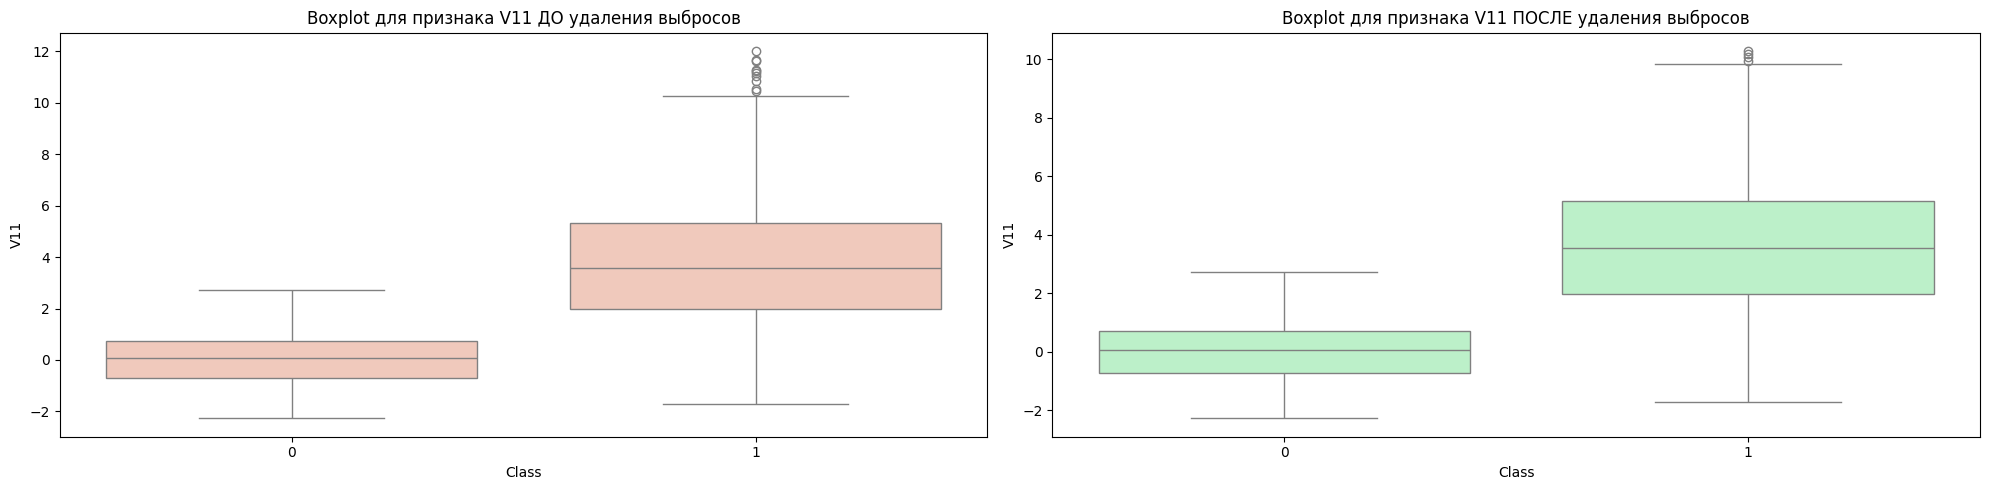

feature = V12
Квартиль 25: -8.688176521812306 | Квартиль 75: -2.97408802538493
iqr: 5.714088496427376
Порог: 8.571132744641064
V12 нижняя граница: -17.25930926645337
V12 верхняя граница: -17.25930926645337
Количество выбросов: 6
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


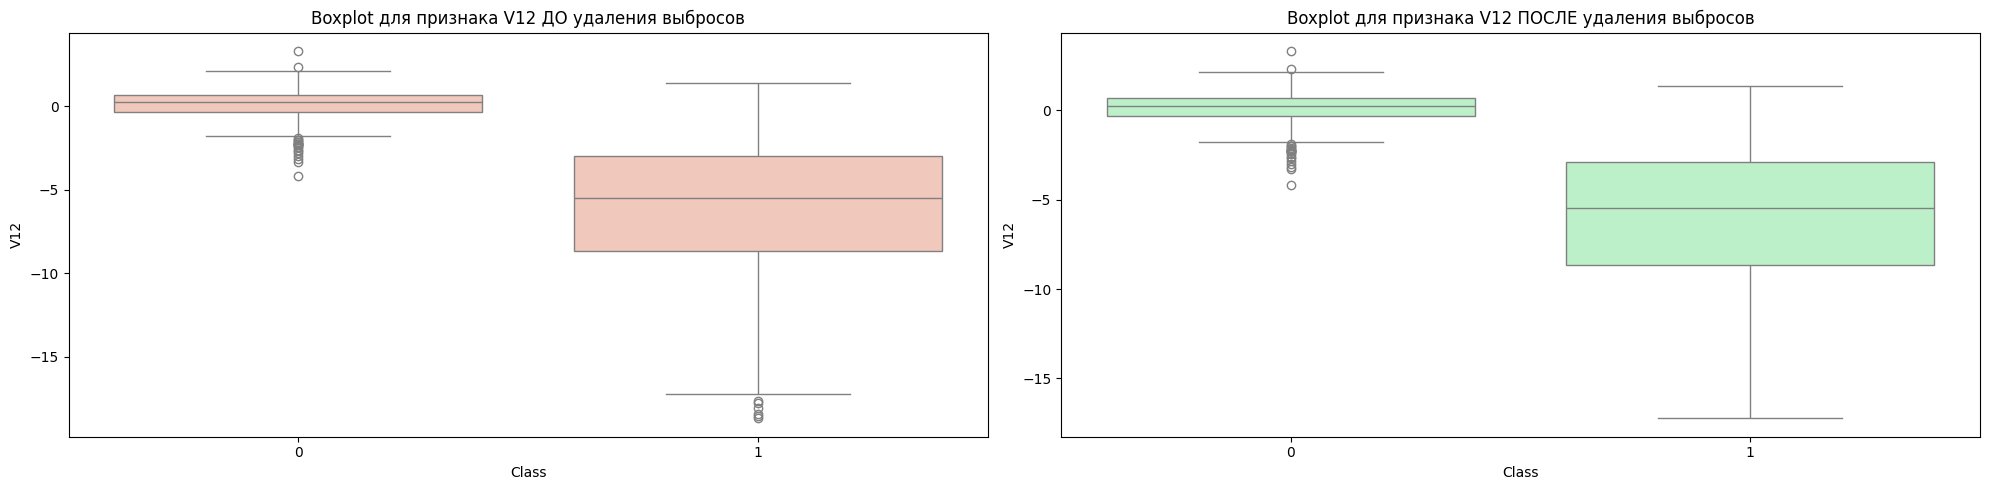

feature = V13
Квартиль 25: -0.9791166043570475 | Квартиль 75: 0.67296399734103
iqr: 1.6520806016980774
Порог: 2.478120902547116
V13 нижняя граница: -3.457237506904163
V13 верхняя граница: -3.457237506904163
Количество выбросов: 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


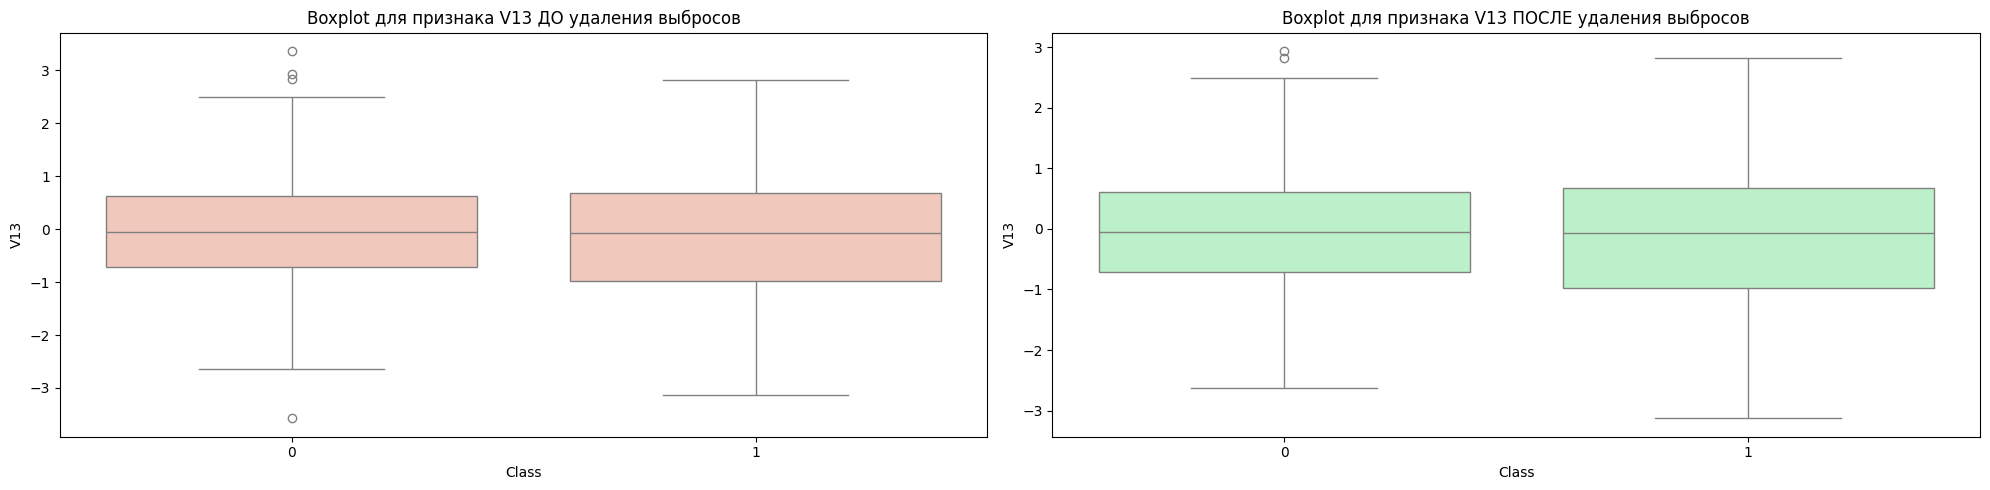

feature = V14
Квартиль 25: -9.692722964972386 | Квартиль 75: -4.282820849486865
iqr: 5.409902115485521
Порог: 8.114853173228282
V14 нижняя граница: -17.807576138200666
V14 верхняя граница: -17.807576138200666
Количество выбросов: 4
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


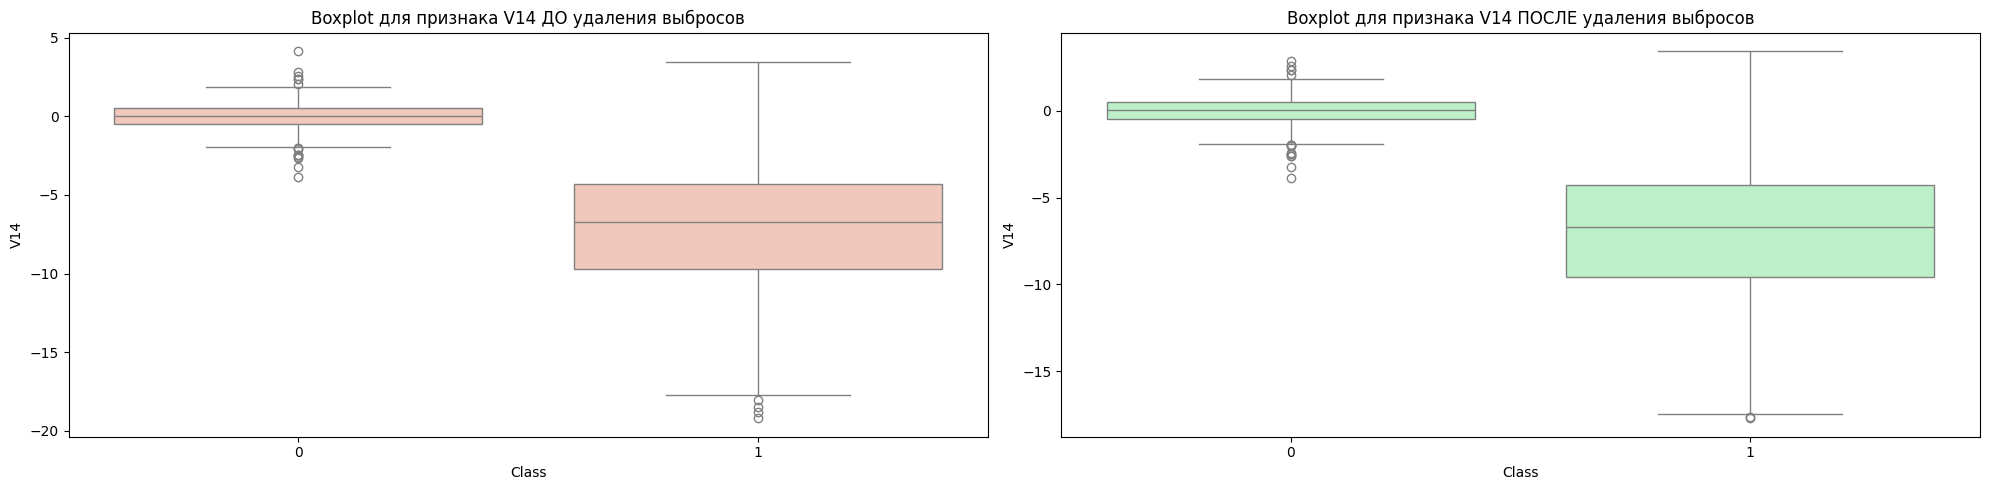

feature = V15
Квартиль 25: -0.6435385270450292 | Квартиль 75: 0.6091891292834305
iqr: 1.2527276563284597
Порог: 1.8790914844926896
V15 нижняя граница: -2.5226300115377187
V15 верхняя граница: -2.5226300115377187
Количество выбросов: 8
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


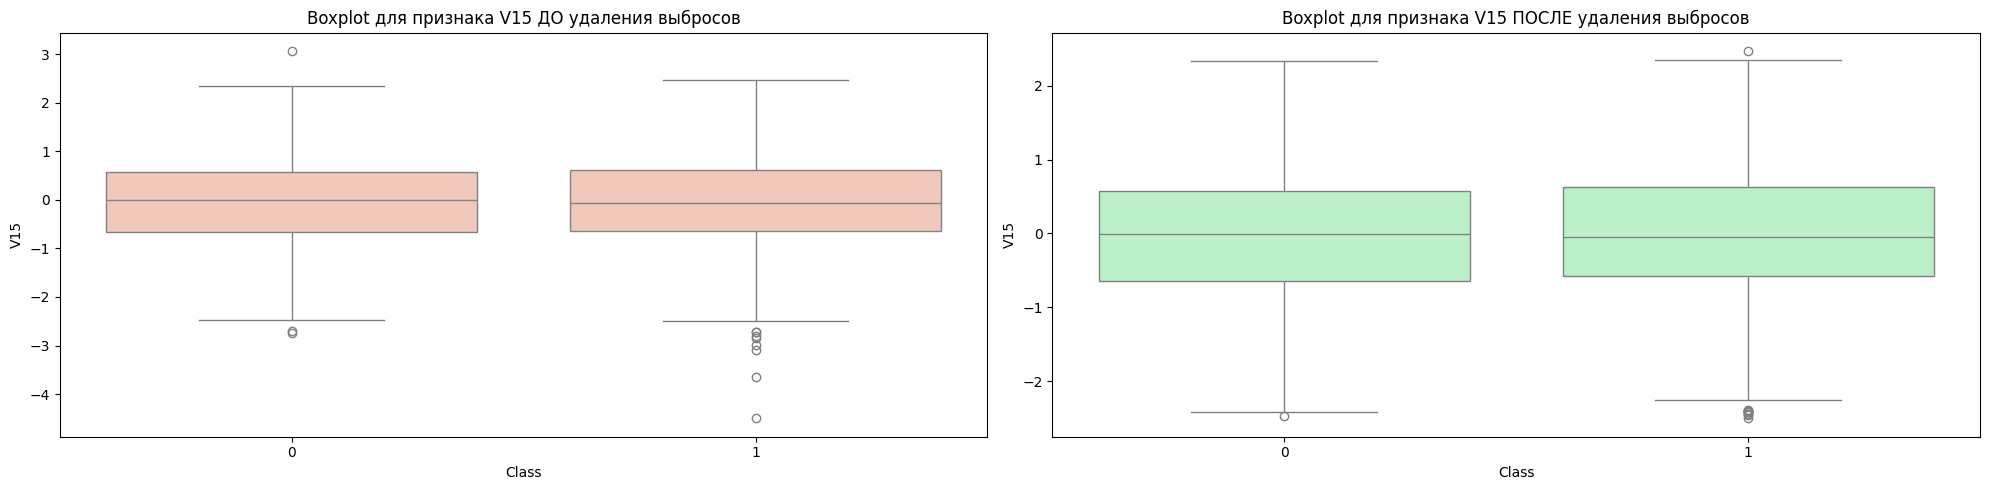

feature = V16
Квартиль 25: -6.562915201970732 | Квартиль 75: -1.22604320393038
iqr: 5.336871998040352
Порог: 8.005307997060529
V16 нижняя граница: -14.56822319903126
V16 верхняя граница: -14.56822319903126
Количество выбросов: 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


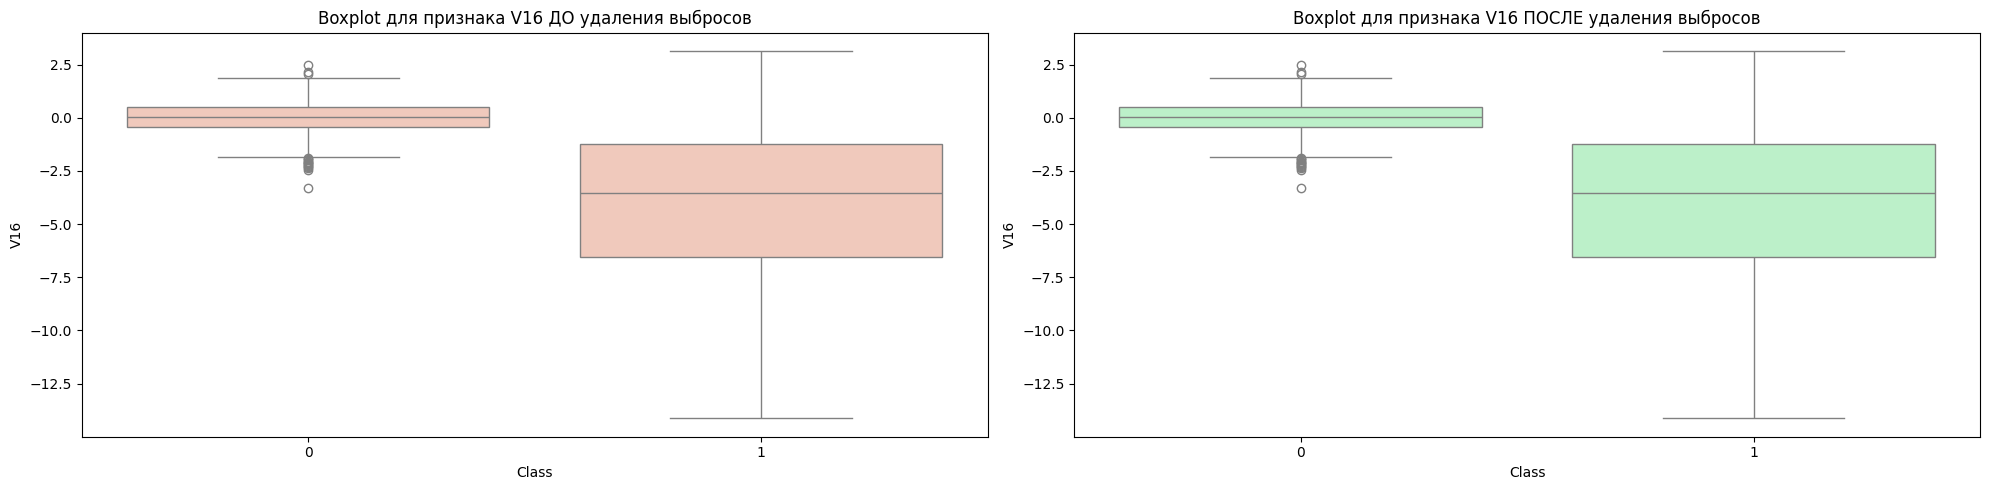

feature = V17
Квартиль 25: -11.945057187644576 | Квартиль 75: -1.34193993162032
iqr: 10.603117256024255
Порог: 15.904675884036383
V17 нижняя граница: -27.84973307168096
V17 верхняя граница: -27.84973307168096
Количество выбросов: 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


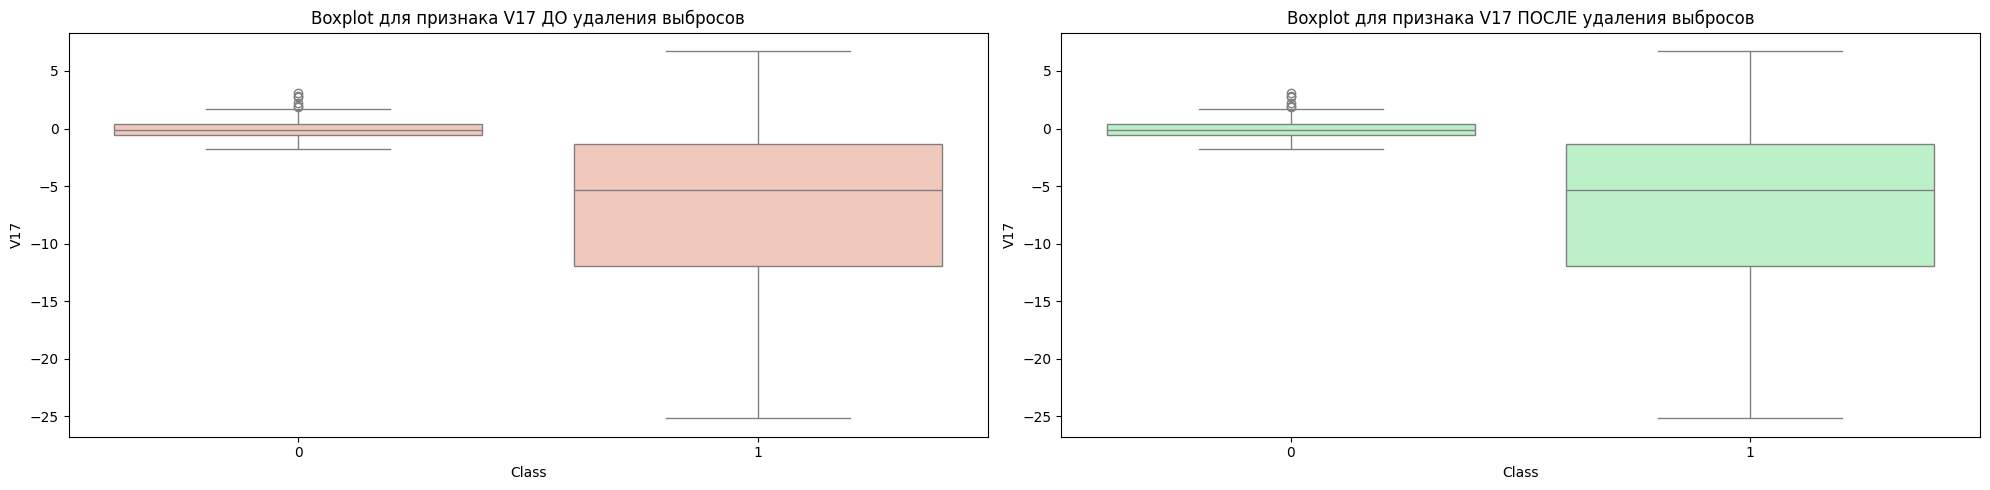

feature = V18
Квартиль 25: -4.664576034701947 | Квартиль 75: 0.0917721039711343
iqr: 4.756348138673082
Порог: 7.1345222080096224
V18 нижняя граница: -11.799098242711569
V18 верхняя граница: -11.799098242711569
Количество выбросов: 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


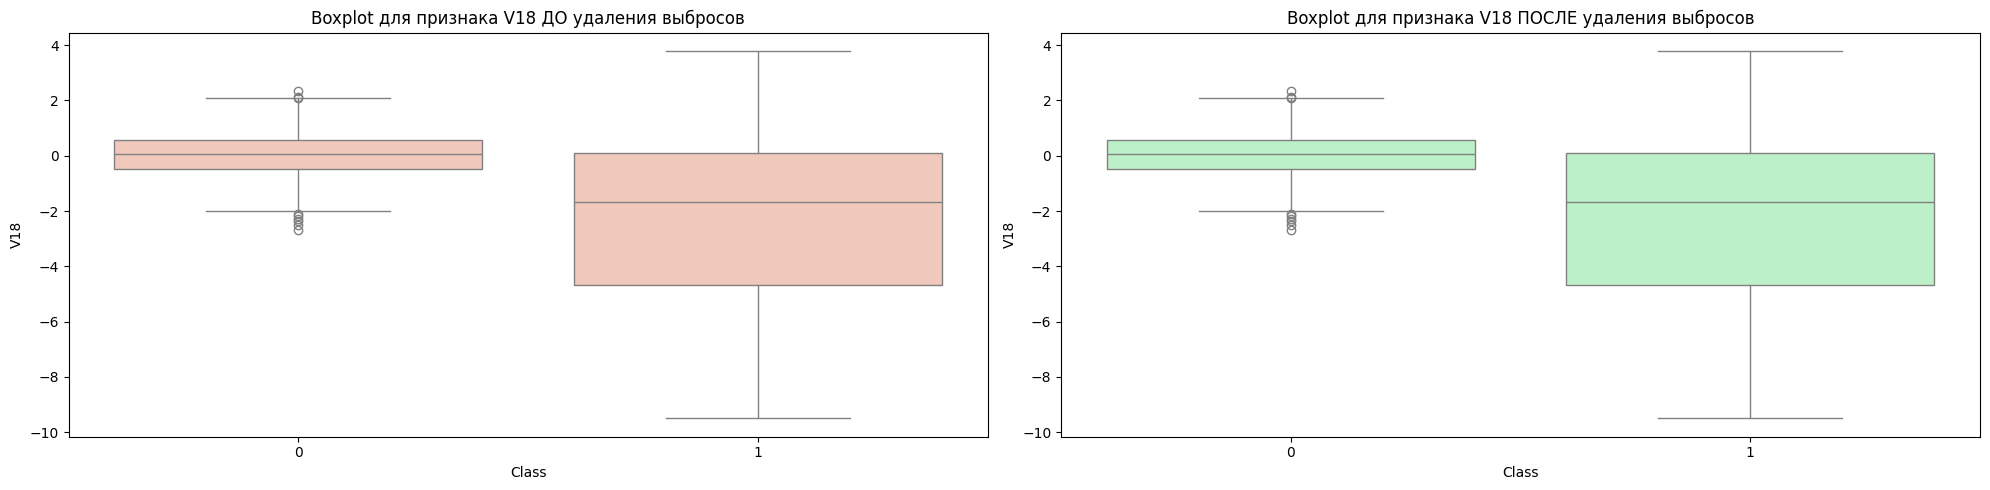

feature = V19
Квартиль 25: -0.29942303620988525 | Квартиль 75: 1.6493177596837325
iqr: 1.9487407958936178
Порог: 2.923111193840427
V19 нижняя граница: -3.222534230050312
V19 верхняя граница: -3.222534230050312
Количество выбросов: 5
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


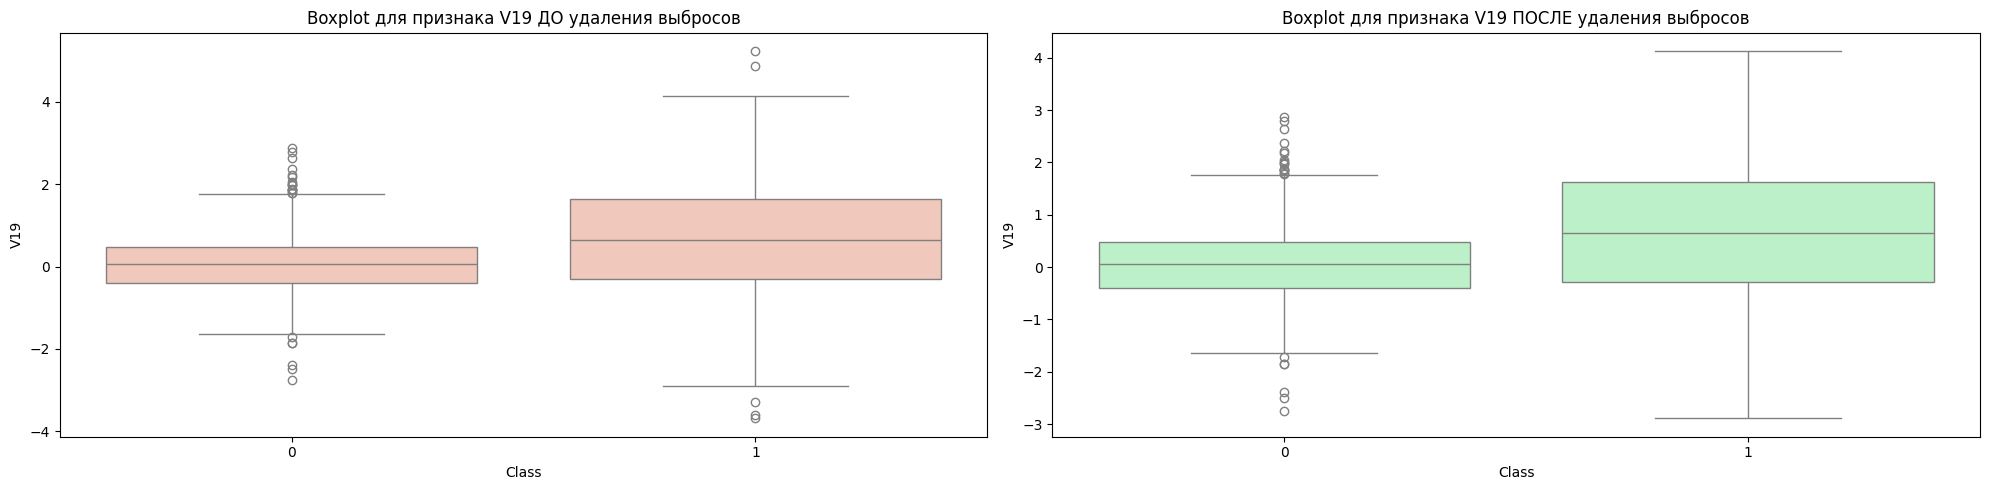

feature = V20
Квартиль 25: -0.17176003336231627 | Квартиль 75: 0.8224449078319616
iqr: 0.9942049411942778
Порог: 1.4913074117914167
V20 нижняя граница: -1.6630674451537328
V20 верхняя граница: -1.6630674451537328
Количество выбросов: 41
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


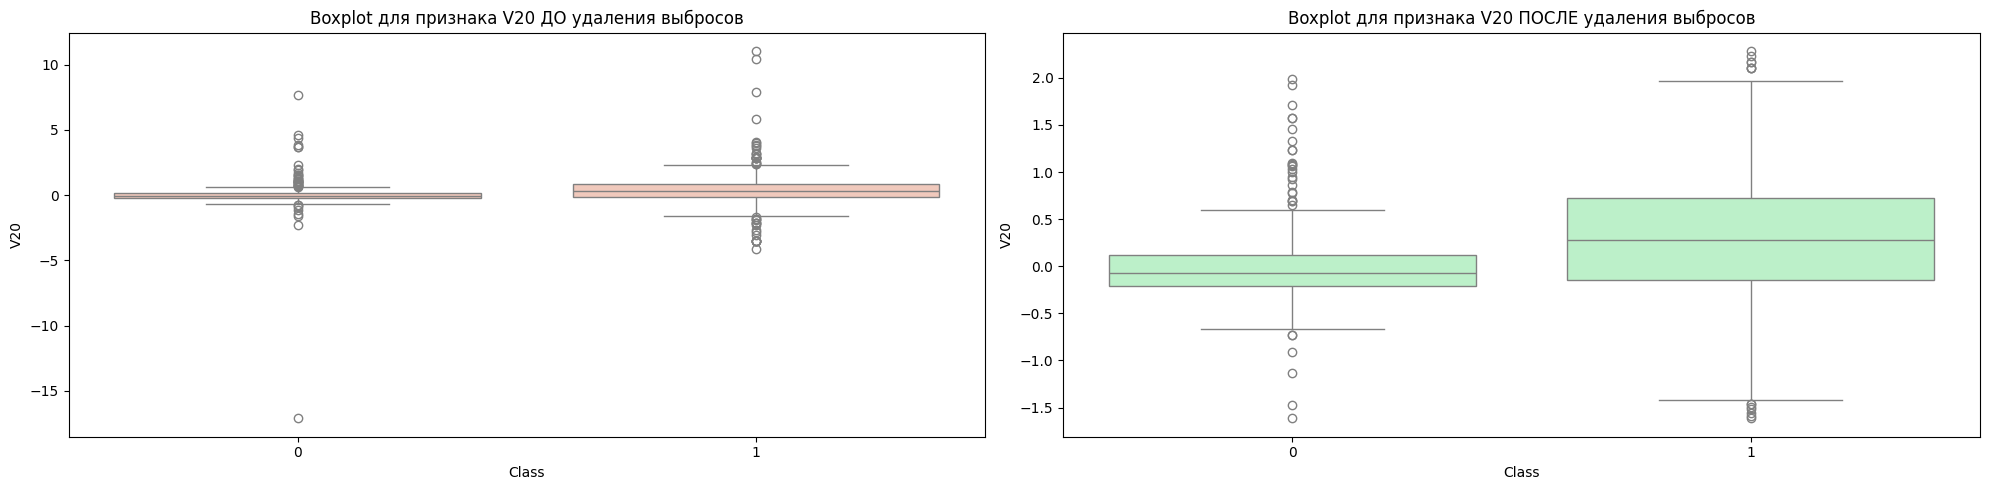

feature = V21
Квартиль 25: 0.04178696495580887 | Квартиль 75: 1.24461062761436
iqr: 1.2028236626585511
Порог: 1.8042354939878267
V21 нижняя граница: -1.7624485290320178
V21 верхняя граница: -1.7624485290320178
Количество выбросов: 49
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


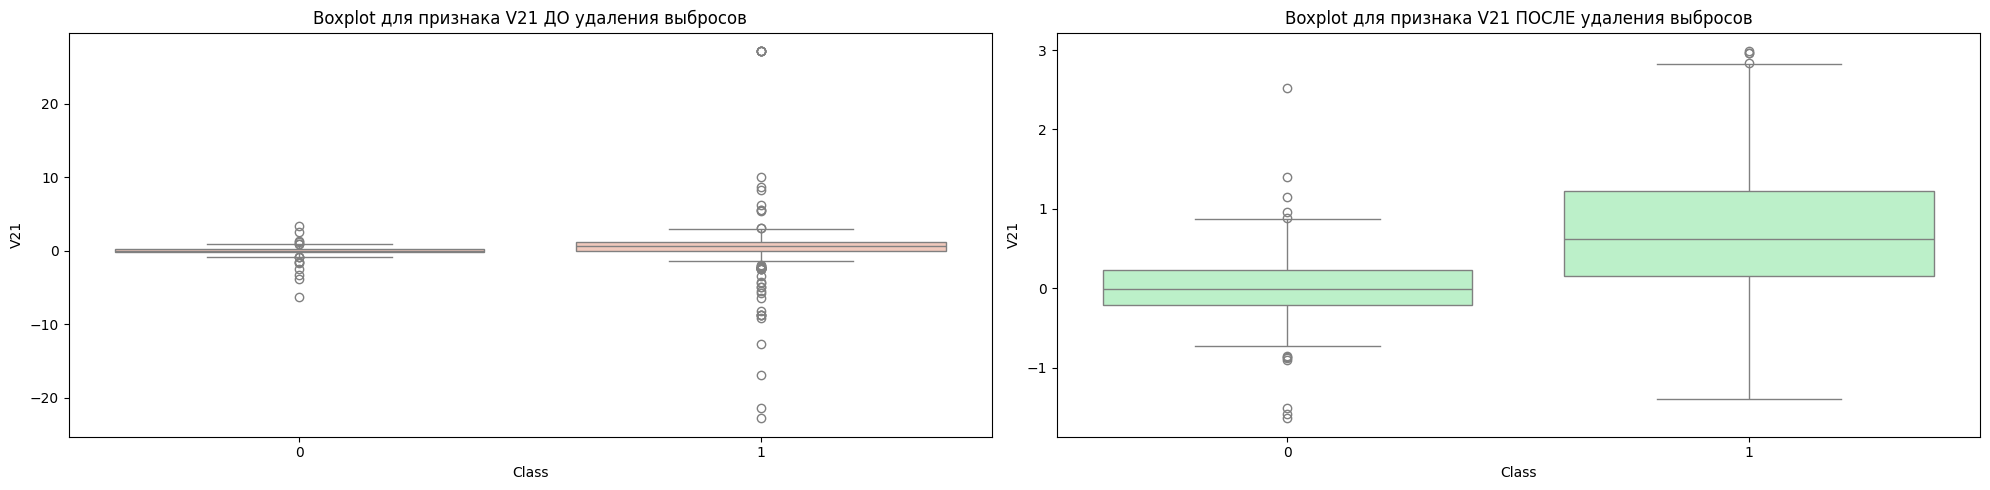

feature = V22
Квартиль 25: -0.5337644990256627 | Квартиль 75: 0.6174743628487113
iqr: 1.1512388618743739
Порог: 1.7268582928115608
V22 нижняя граница: -2.2606227918372235
V22 верхняя граница: -2.2606227918372235
Количество выбросов: 24
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


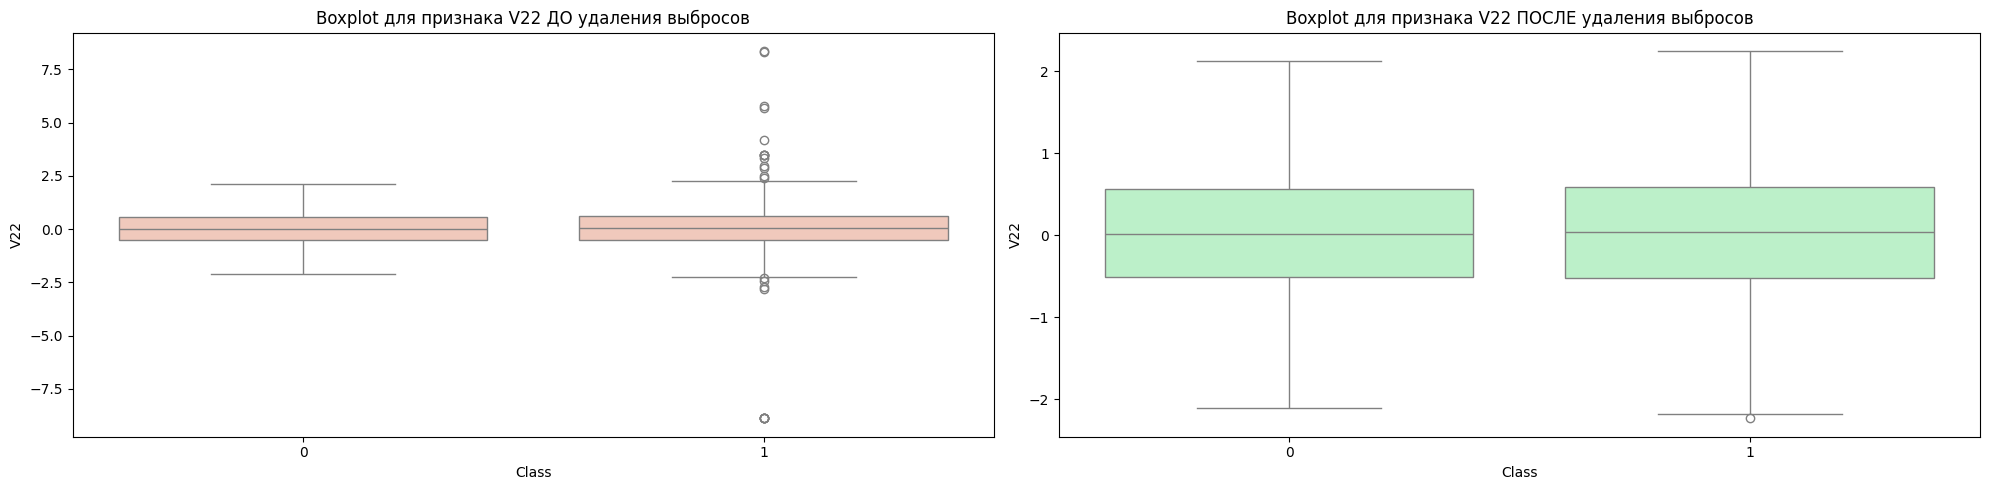

feature = V23
Квартиль 25: -0.3421751596532043 | Квартиль 75: 0.30837812121152874
iqr: 0.650553280864733
Порог: 0.9758299212970994
V23 нижняя граница: -1.3180050809503037
V23 верхняя граница: -1.3180050809503037
Количество выбросов: 59
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


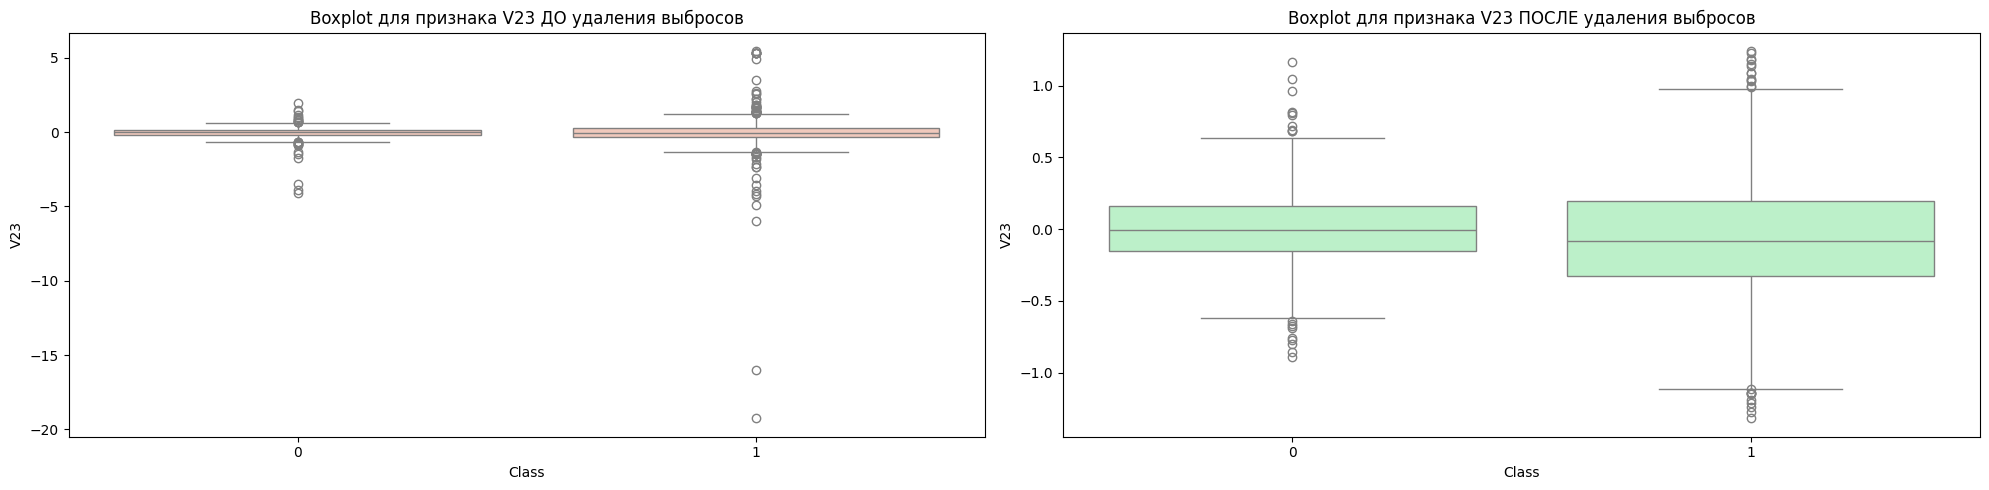

feature = V24
Квартиль 25: -0.4368087922122402 | Квартиль 75: 0.28532797679163324
iqr: 0.7221367690038735
Порог: 1.0832051535058103
V24 нижняя граница: -1.5200139457180506
V24 верхняя граница: -1.5200139457180506
Количество выбросов: 3
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


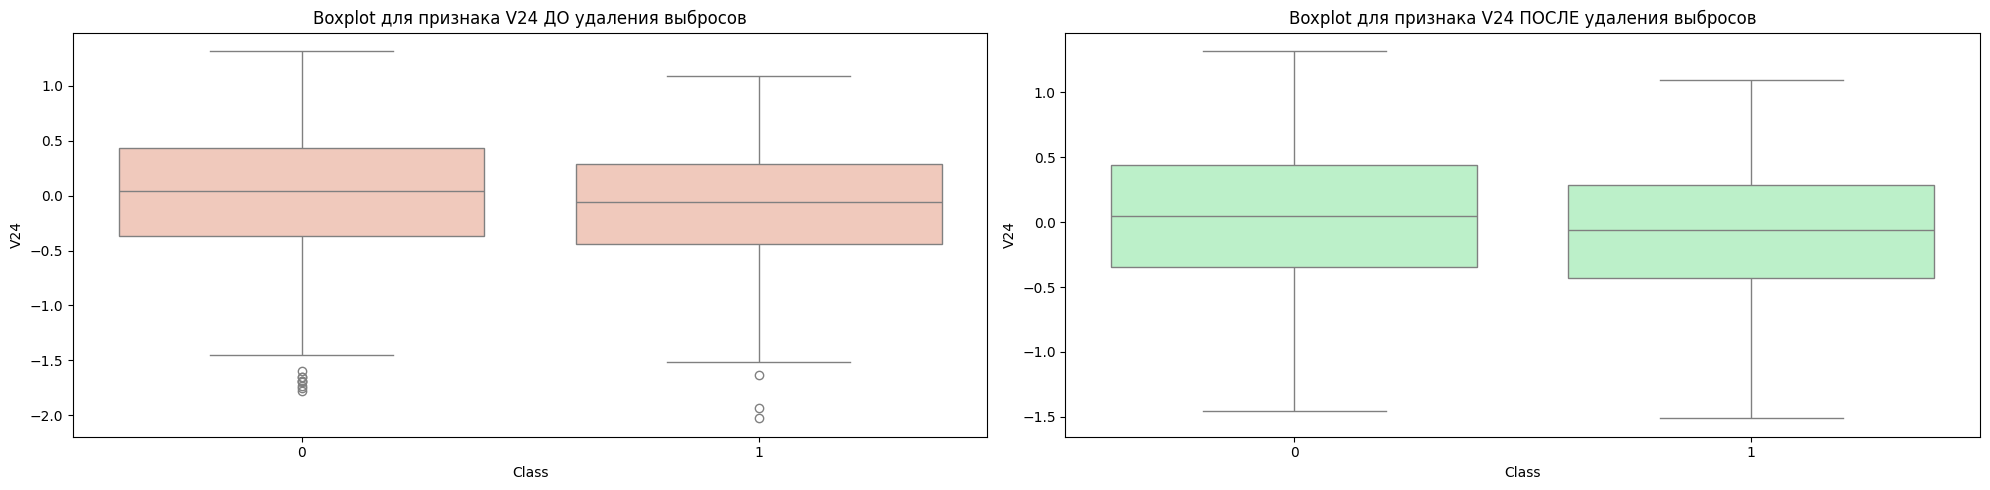

feature = V25
Квартиль 25: -0.3143482787641487 | Квартиль 75: 0.456514808553085
iqr: 0.7708630873172337
Порог: 1.1562946309758506
V25 нижняя граница: -1.4706429097399993
V25 верхняя граница: -1.4706429097399993
Количество выбросов: 36
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


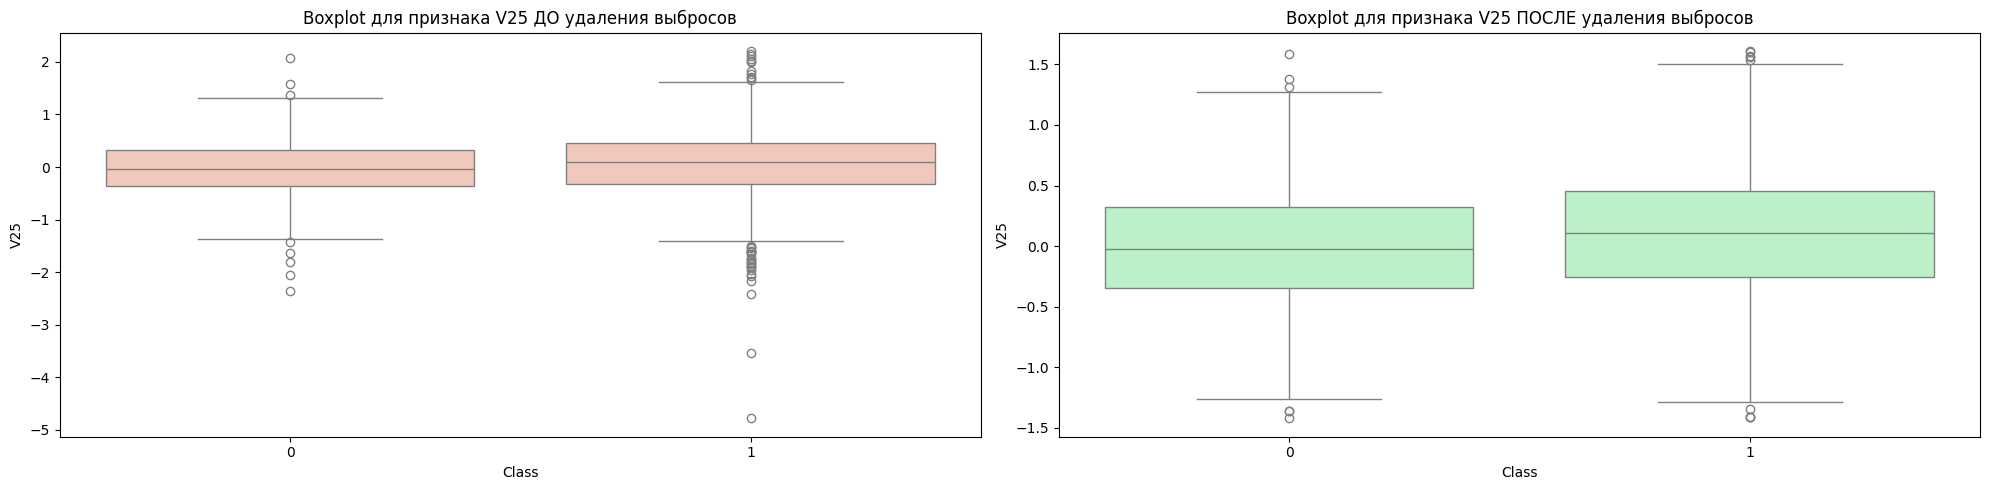

feature = V26
Квартиль 25: -0.259416242027874 | Квартиль 75: 0.3967328794767663
iqr: 0.6561491215046402
Порог: 0.9842236822569603
V26 нижняя граница: -1.2436399242848344
V26 верхняя граница: -1.2436399242848344
Количество выбросов: 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


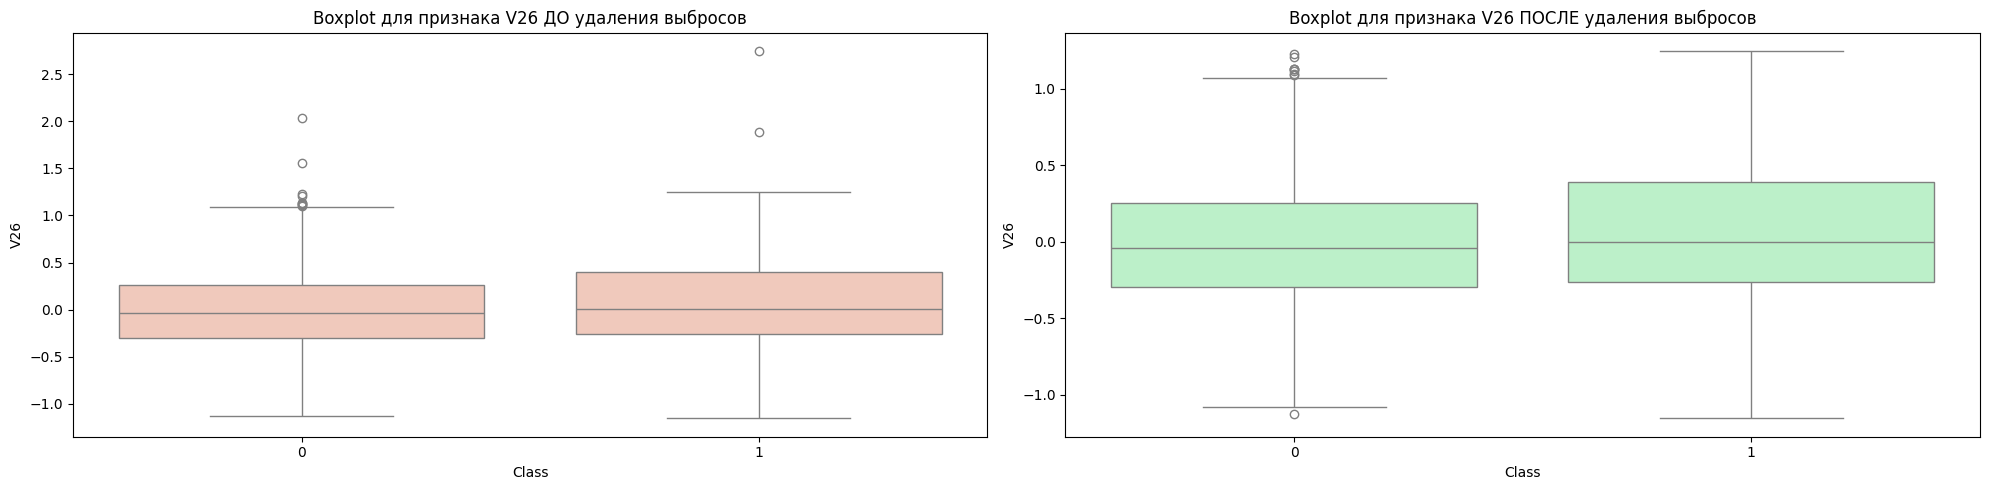

feature = V27
Квартиль 25: -0.02002488071085485 | Квартиль 75: 0.8260294974751907
iqr: 0.8460543781860456
Порог: 1.2690815672790683
V27 нижняя граница: -1.2891064479899232
V27 верхняя граница: -1.2891064479899232
Количество выбросов: 70
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


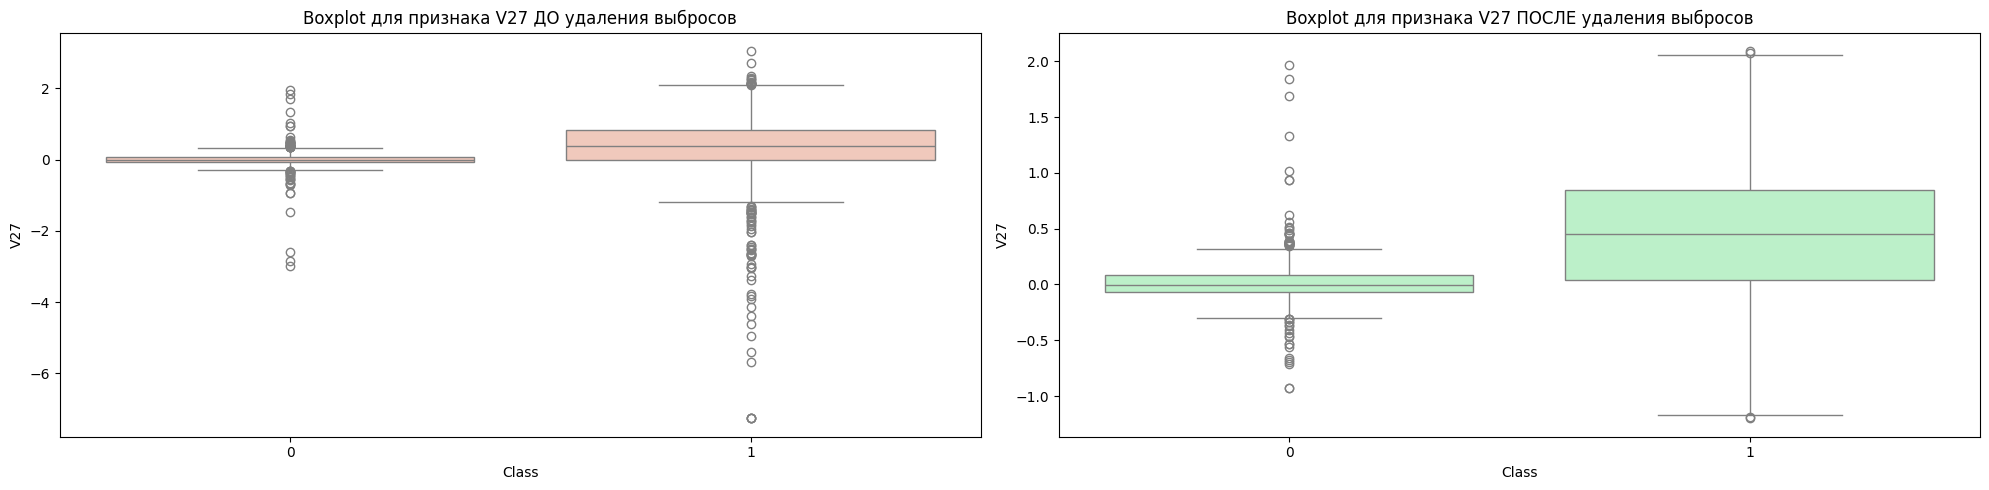

feature = V28
Квартиль 25: -0.108868107923736 | Квартиль 75: 0.3811518707176925
iqr: 0.49001997864142854
Порог: 0.7350299679621428
V28 нижняя граница: -0.8438980758858788
V28 верхняя граница: -0.8438980758858788
Количество выбросов: 46
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


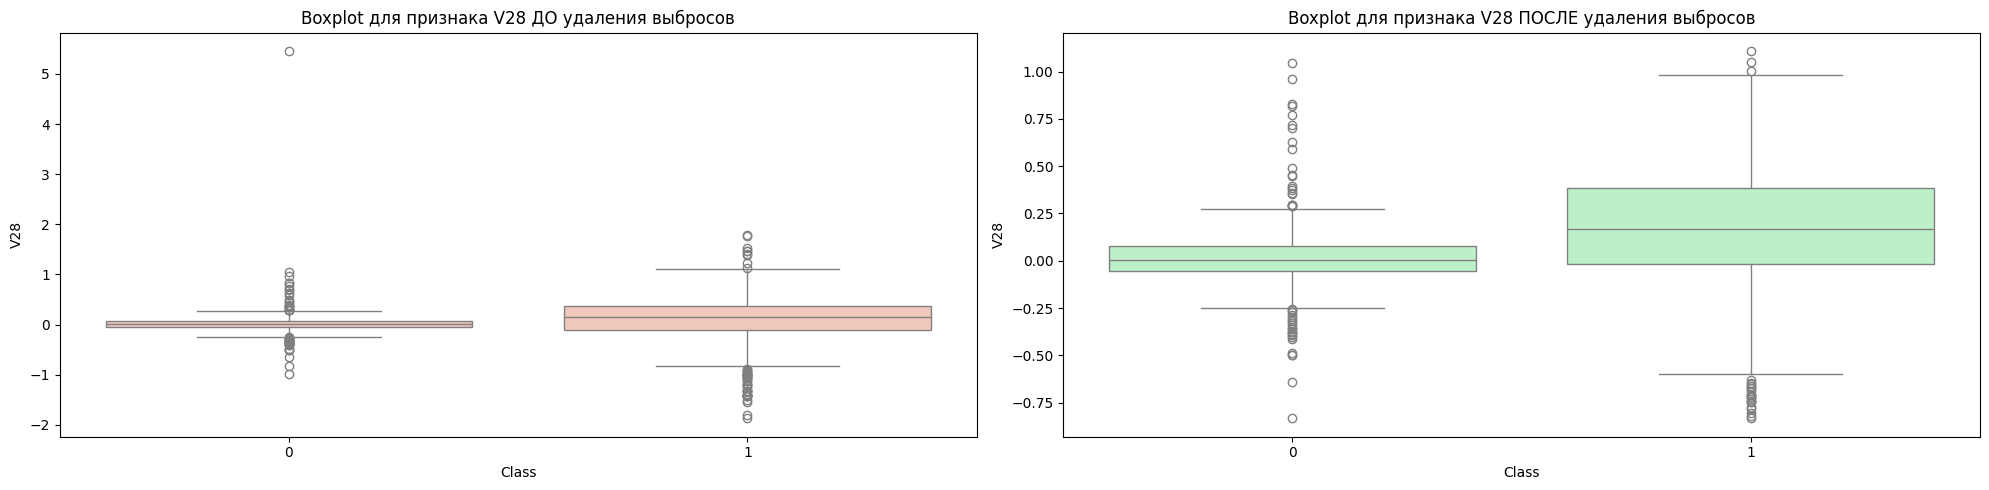

feature = Amount
Квартиль 25: 1.0 | Квартиль 75: 105.89
iqr: 104.89
Порог: 157.335
Amount нижняя граница: -156.335
Amount верхняя граница: -156.335
Количество выбросов: 69
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


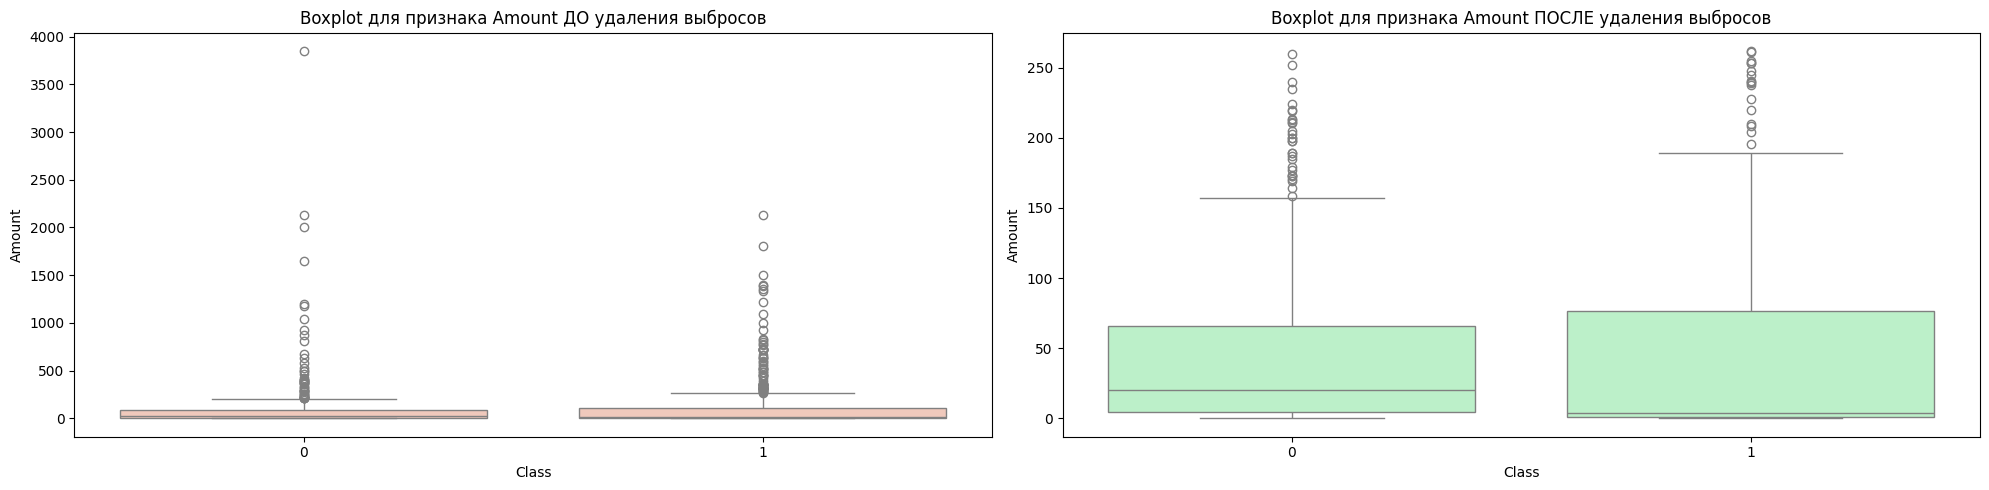

feature = Class
Квартиль 25: 1.0 | Квартиль 75: 1.0
iqr: 0.0
Порог: 0.0
Class нижняя граница: 1.0
Class верхняя граница: 1.0
Количество выбросов: 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


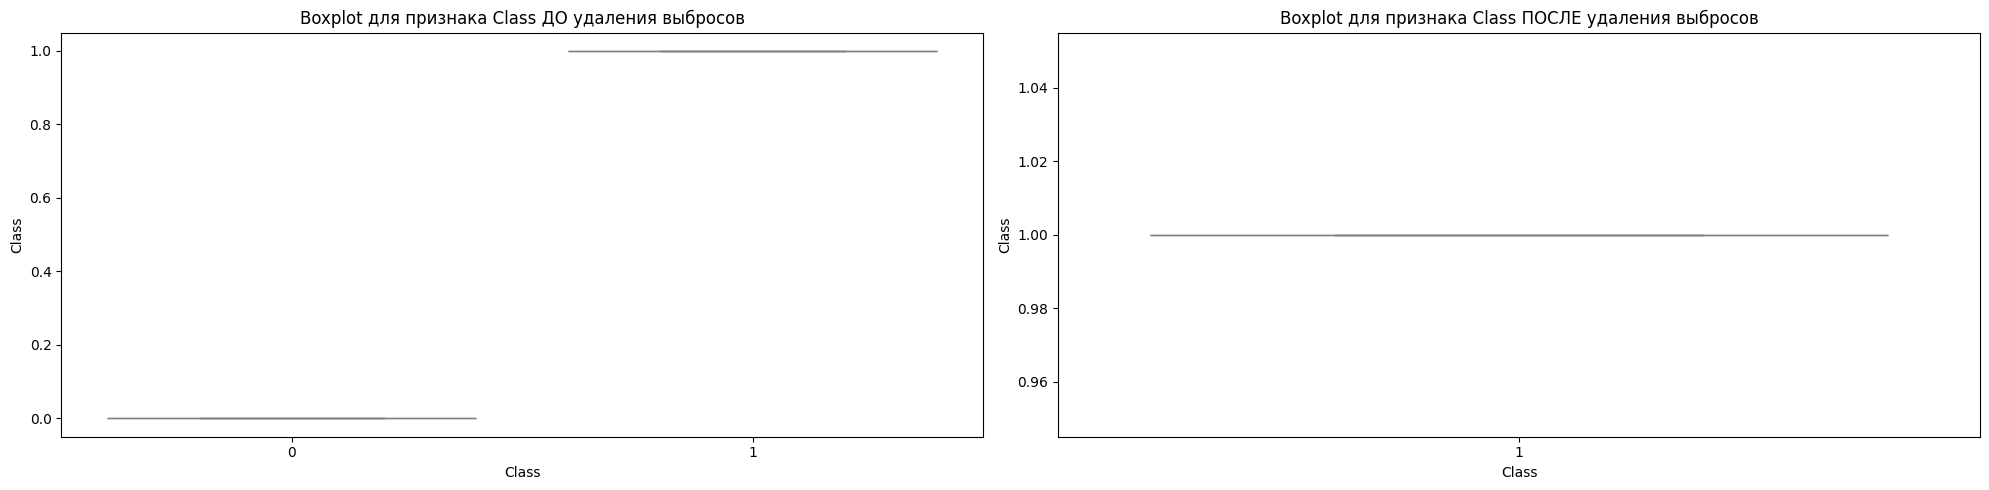

In [47]:
# Применение функции для признаков
features_to_check = new_df.columns.to_list()  # Пример списка признаков
print(features_to_check)
ned_df_cleaned = new_df.copy()
for feature in features_to_check:
    new_df_cleaned = plot_outliers(ned_df_cleaned, feature)

### Понижение размерности и кластеризация

Для того, чтобы убедиться, что наши классы являются разделимыми (иначе строить модели нет смысла), выполним кластеризацию с помощью трех различных техник кластеризации.



In [48]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

X = new_df.drop('Class', axis=1)
y = new_df['Class']

X.drop(['Time','Amount'], axis=1, inplace=True) # Tак как Time и Amount не коррелируют почти с таргетом


# T-SNE алгоритм
t0 = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)
t1 = time.time()
print("T-SNE заняло {:.2} сек".format(t1 - t0))

# PCA алгоритм
t0 = time.time()
pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(X)
t1 = time.time()
print("PCA заняло {:.2} сек".format(t1 - t0))

# TruncatedSVD алгоритм
t0 = time.time()
svd = TruncatedSVD(n_components=2)
X_reduced_svd = svd.fit_transform(X)
t1 = time.time()
print("Truncated SVD заняло {:.2} сек".format(t1 - t0))

T-SNE заняло 9.2 сек
PCA заняло 0.026 сек
Truncated SVD заняло 0.0089 сек


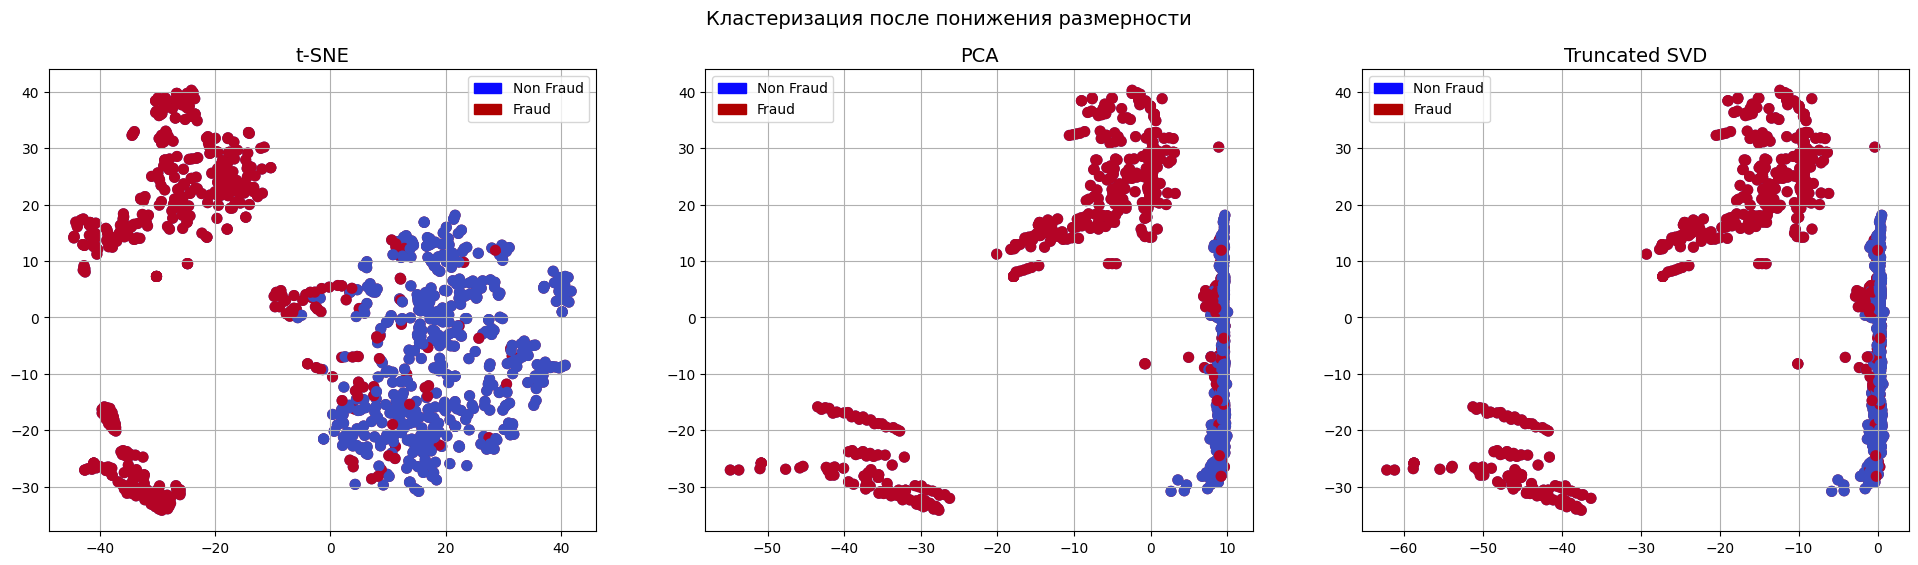

In [49]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Кластеризация после понижения размерности', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='Non Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])


plt.show()

<h3> Выводы: </h3>
<ul>
<li>Алгоритм t-SNE может довольно точно кластеризовать случаи мошенничества и не мошенничества в нашем наборе данных. </li>
<li> Классы целевой переменной однозначно разделимы, а значит мы можем строить модели! </li>
</ul>

## Продолжение следует .....



<h3 style="text-align: center;">Материалы для изучения scikit-learn:<b></b></h3>

*1) Официальный сайт с подробными описаниями моделей и методов : https://scikit-learn.org/stable/user_guide.html*

*2) Полезный репозиторий с блокнотами: https://github.com/gmonce/scikit-learn-book*

*3) Хороший курс с упражнениями: https://inria.github.io/scikit-learn-mooc/*

In [50]:
new_df.to_csv('/content/drive/MyDrive/Colab Notebooks/creditcard_short.csv')